# Step 2: Agent-based simulation


Setup code

In [2]:
# Install and import required packages
import sys
!{sys.executable} -m pip install numpy pandas networkx matplotlib seaborn tqdm
import os
import glob
import time
import random
import re
import warnings
import itertools
import datetime
import pathlib
from pathlib import Path
from math import ceil
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from tqdm import tqdm


def ensure_python_igraph():
    try:
        import igraph as ig  # already installed and importable
        return ig
    except Exception:
        pass

    # Install only if not importable yet
    try:
        # python-igraph is the correct package name on PyPI
        # cairocffi enables plotting without apt-get
        !python -m pip install -q python-igraph cairocffi
    except Exception as e:
        print("pip install failed:", e)

    # Try import again
    try:
        import igraph as ig
        return ig
    except Exception as e:
        # As a fallback, try pycairo if cairocffi was not enough
        try:
            !python -m pip install -q pycairo
            import igraph as ig
            return ig
        except Exception as e2:
            raise ImportError(
                "igraph could not be imported after install. "
                "If this is a reused session that already imported an old igraph, "
                "use Runtime -> Restart runtime once and re-run this cell first."
            ) from e2

ig = ensure_python_igraph()
print("igraph version:", ig.__version__)

# Optional: quick self-test (no plotting)
g = ig.Graph.Erdos_Renyi(n=5, m=6)
print("Test graph:", g.summary())

# Step 2 setup: consistent folders for reading Step 1 outputs and writing Step 2 outputs
import os
from pathlib import Path

def in_colab():
    return "COLAB_RELEASE_TAG" in os.environ or "COLAB_GPU" in os.environ

PROJECT_ROOT = Path.cwd()

if in_colab():
    try:
        from google.colab import drive  # type: ignore
        drive.mount("/content/drive", force_remount=False)
        drive_proj = Path("/content/drive/MyDrive/Negotiations-as-Search")
        if drive_proj.exists():
            PROJECT_ROOT = drive_proj
    except Exception as e:
        print("Drive not mounted:", e)

# Constant folders (your chosen naming)
S1_OUTPUT = PROJECT_ROOT / "S1_OUTPUT"   # inputs for Step 2
S2_OUTPUT = PROJECT_ROOT / "S2_OUTPUT"   # outputs from Step 2
S1_OUTPUT.mkdir(parents=True, exist_ok=True)
S2_OUTPUT.mkdir(parents=True, exist_ok=True)

print("Project root:", PROJECT_ROOT)
print("Step 1 outputs (read from):", S1_OUTPUT)
print("Step 2 outputs (write to): ", S2_OUTPUT)
# Short helpers
def s1out(name): return S1_OUTPUT / name
def s2out(name): return S2_OUTPUT / name


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.8 MB/s eta 0:00:00
igraph version: 1.0.0
Test graph: IGRAPH U--- 5 6 -- 
Mounted at /content/drive
Project root: /content/drive/MyDrive/Negotiations-as-Search
Step 1 outputs (read from): /content/drive/MyDrive/Negotiations-as-Search/S1_OUTPUT
Step 2 outputs (write to):  /content/drive/MyDrive/Negotiations-as-Search/S2_OUTPUT


### Simulation Helper Functions
Run the cell below to load all the helper functions used for the simulation

In [ ]:
# -------------------------------------------------------------------
#  Transition‑rule filter  (2025‑05‑16 final)
# -------------------------------------------------------------------
def apply_transition_rules_to_dataframe(df: pd.DataFrame,
                                        rule_number: int) -> pd.DataFrame:
    def _none(series):
        """True for NA, None or the string 'None'."""
        return series.isna() | (series == "None")

    if rule_number == 1:                  # vote‑gain only
        cond = df["Vote_Change"] > 0

    elif rule_number == 2:                # tie‑resolution
        # keep all ties; keep any edge with a positive vote gain
        cond = (df["Vote_Change"] > 0) | (df["Vote_Change"] == 0)

    elif rule_number == 3:                # proposer‑accept
        # positive votes must also satisfy a non‑empty Accepting list
        cond = ((df["Vote_Change"] > 0) & ~_none(df["Accepting"])) | \
               (df["Vote_Change"] == 0)

    elif rule_number == 4:                # Pareto
        cond = (df["Vote_Change"] > 0) | (df["Vote_Change"] == 0)

    else:                                 # joint‑payoff (legacy)
        cond = (df["Vote_Change"] > 0) | \
               ((df["Vote_Change"] == 0) & (df["Payoff_Change"] > 0))

    return df[cond].copy()

### Extracting party names (used in transition rule code1)
def extract_parties(df):
    """
    Extracts the list of parties from the DataFrame columns based on the pattern [party name]_destination_payoff.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing negotiation data.

    Returns:
    list: A list of unique party names.
    """
    party_columns = [col for col in df.columns if '_destination_payoff' in col]
    parties = [col.replace('_destination_payoff', '') for col in party_columns]
    return list(set(parties))


def set_agreement_threshold(nego_df, N, rule_choice):
    """
    Sets the agreement threshold based on the specified rule.

    Parameters:
    nego_df (DataFrame): The negotiation Data.Frame.
    N (int): Number of parties.
    rule_choice (int): The choice of rule.
                       1 for simple majority threshold,
                       2 for max votes minus one.

    Returns:
    DataFrame: The updated negotiation DataFrame with new agreement columns.
    """
    if rule_choice == 1:
        # Majority threshold ule
        majority_threshold = N // 2
        # nego_df['Origin_Agreement'] = ((nego_df['Origin_votes'] > majority_threshold) & (nego_df['Origin_veto'] == 'No')).astype(int)
        nego_df['Origin_Agreement'] = ((nego_df['Origin_votes'] > majority_threshold)).astype(int)
        # nego_df['Destination_Agreement'] = ((nego_df['Destination_votes'] > majority_threshold) & (nego_df['Destination_veto'] == 'No')).astype(int)
        nego_df['Destination_Agreement'] = ((nego_df['Destination_votes'] > majority_threshold)).astype(int)
    elif rule_choice == 2:
        # Max votes minus one rule
        agreement_threshold = max(nego_df['Origin_votes']) - 1
        nego_df['Origin_Agreement'] = ((nego_df['Origin_votes'] >= agreement_threshold) & (nego_df['Origin_veto'] == 'No')).astype(int)
        nego_df['Destination_Agreement'] = ((nego_df['Destination_votes'] >= agreement_threshold) & (nego_df['Destination_veto'] == 'No')).astype(int)
    elif rule_choice == 3:
        # Unanimous vote agreement rule
        unanimous_threshold = N  # Agreement threshold is equal to the number of parties
        nego_df['Origin_Agreement'] = (nego_df['Origin_votes'] == unanimous_threshold).astype(int)
        nego_df['Destination_Agreement'] = (nego_df['Destination_votes'] == unanimous_threshold).astype(int)
    else:
        raise ValueError("Invalid rule choice. Please select 1, 2, or 3.")

    return nego_df

### Extracting party names (used in transition rule code1)
def extract_parties(df):
    """
    Extracts the list of parties from the DataFrame columns based on the pattern [party name]_destination_payoff.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing negotiation data.

    Returns:
    list: A list of unique party names.
    """
    party_columns = [col for col in df.columns if '_destination_payoff' in col]
    parties = [col.replace('_destination_payoff', '') for col in party_columns]
    return list(set(parties))

### TRANSITION RULE
def apply_transition_rules_to_dataframe(df, rule_number):
    """
    Applies specified transition rules to the DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame on which to apply the transition rules.
    rule_number (int): The number of the transition rule to apply.

    Rules:
    1. Keep rows if 'Vote_Change' is strictly positive.
    2. Keep rows if 'Vote_Change' is positive. If 'Vote_Change' is zero, keep if 'Payoff_Change' (inc. in joint pay-offs) is positive.
    3. Keep rows if 'Vote_Change' is positive. If 'Vote_Change' is zero, keep if 'Worse_Off' is 'None'.
    4. (Concessions Rule) Randomly selects one party and transitions to the node where this party's payoff is the highest.
    """

    # Ensure the rule_number is valid
    if rule_number not in [1, 2, 3, 4]:
        raise ValueError("Invalid rule number. Please select 1, 2, 3, or 4.")

    # Define the conditions for keeping rows based on the rule
    if rule_number == 1:
        # Strictly increase in votes
        condition = (df['Vote_Change'] > 0)
    elif rule_number == 2:
        # Increase in total vote count or if votes are equal, then increase in joint payoff
        condition = (df['Vote_Change'] > 0) | ((df['Vote_Change'] == 0) & (df['Payoff_Change'] > 0))
    elif rule_number == 3:
        # Increase in total vote count or if votes are equal, then pareto Superiority applies (consider outcomes where no one should be worse off)
        condition = (df['Vote_Change'] > 0) | ((df['Vote_Change'] == 0) & (df['Worse_Off'] == 'None'))
    elif rule_number == 4:
        # Concessions Rule: Transitions based on maximizing the payoff for a randomly selected party.
        parties = extract_parties(df)
        selected_party = random.choice(parties)
        payoff_column = f"{selected_party}_destination_payoff"
        df['Selected_Party_Payoff'] = df[payoff_column]
        max_payoff = df['Selected_Party_Payoff'].max()
        condition = df['Selected_Party_Payoff'] == max_payoff
    else:
        raise ValueError("Unexpected rule number.")

    # Filter the DataFrame based on the condition
    filtered_df = df[condition].copy()

    # Clean up the temporary column if used
    if 'Selected_Party_Payoff' in filtered_df.columns:
        del filtered_df['Selected_Party_Payoff']

    return filtered_df

import math
import random
import pandas as pd
from tqdm import tqdm

###############################################################################
# Utility functions for proposal extraction from the negotiation DataFrame.
###############################################################################

def hamming_distance(s1, s2):
    """Compute the Hamming distance between two strings (assumes equal length)."""
    s1, s2 = str(s1), str(s2)
    if len(s1) != len(s2):
        return max(len(s1), len(s2))
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))

def get_filler_offers_for_anchor(anchor, nego_df, fill_search_distance=1):
    """
    Given an anchoring offer (anchor), return a list of potential filler offers from nego_df's Destination column.
    Only offers with Hamming distance <= fill_search_distance (and not equal to anchor) are returned.
    """
    candidates = nego_df['Destination'].unique().tolist()
    fillers = [offer for offer in candidates if offer != anchor and hamming_distance(offer, anchor) <= fill_search_distance]
    return list(set(fillers))  # ensure uniqueness

def _get_dest_payoffs(offer, df, parties):
    row = df.loc[df["Destination"] == offer]
    if row.empty:
        return {p: None for p in parties}
    row = row.iloc[0]
    return {p: row.get(f"{p}_destination_payoff", None) for p in parties}

def _attach_final_payoffs(runs, nego_df, rp_df):
    parties = rp_df["Party"].tolist()
    rp_map  = rp_df.set_index("Party")["Reservation"].to_dict()
    for p in parties:
        runs[f"{p}_Final_Payoff"] = [
            _get_dest_payoffs(r.end_node, nego_df, parties).get(p, 0)
            if r.agreement and r.end_node is not None else rp_map.get(p, 0)
            for _, r in runs.iterrows()
        ]

def extract_parties_max_payoff(df, top_value=3, top_percent=True, random_seed=None):
    """
    Extract the top payoff proposals for each party from the provided DataFrame.

    Parameters:
      df (DataFrame): The negotiation DataFrame. It should include columns named like "<party>_origin_payoff"
                      and an "Origin" column with the proposal IDs.
      top_value (int or float, default=3):
          - If top_percent is False, top_value is the number of proposals to keep.
          - If top_percent is True, top_value (0 < top_value <= 100) is interpreted as a percentage.
      top_percent (bool, default=True):
          - If True, returns the top (top_value)% of proposals for each party.
          - If False, returns the top top_value proposals.
      random_seed (int, optional): A seed for reproducible random tie-breaks.

    Returns:
      dict: Mapping each party (inferred from the payoff column names) to a list of proposals in the top segment.
    """
    if random_seed is not None:
        random.seed(random_seed)

    parties_top_payoff = {}
    for col in df.columns:
        if '_origin_payoff' in col:
            party_name = col.replace('_origin_payoff', '')
            party_df = df[['Origin', col]].dropna()
            party_df = party_df.drop_duplicates(subset='Origin')
            party_df = party_df.sort_values(by=col, ascending=False).reset_index(drop=True)
            # Determine how many proposals to take.
            if top_percent:
                n_total = len(party_df)
                n_take = max(1, math.ceil(n_total * top_value / 100))
            else:
                n_take = int(top_value)
            # Handle ties at the boundary.
            if n_take < len(party_df):
                boundary_value = party_df.iloc[n_take - 1][col]
                count_above = (party_df[col] > boundary_value).sum()
                spots = n_take - count_above
                tied_rows = party_df[party_df[col] == boundary_value]
                selected_rows = party_df[party_df[col] > boundary_value]
                selected_proposals = selected_rows['Origin'].tolist()
                tied_proposals = tied_rows['Origin'].tolist()
                if spots < len(tied_proposals):
                    selected_tied = random.sample(tied_proposals, spots)
                else:
                    selected_tied = tied_proposals
                result_proposals = selected_proposals + selected_tied
            else:
                result_proposals = party_df.head(n_take)['Origin'].tolist()
            parties_top_payoff[party_name] = result_proposals
    return parties_top_payoff

def create_payoff_reports_with_votes(df, parties_top_payoff, filtered_df_hamming=None,
                                     top_value=3, top_percent=True, random_seed=None):
    """
    Create a payoff report with votes using the given parties_top_payoff dictionary.

    Parameters:
      df (DataFrame): The negotiation DataFrame.
      parties_top_payoff (dict): Mapping from parties to a list of proposals.
      filtered_df_hamming (DataFrame, optional): Used for additional checking.
      top_value (int or float, default=3) and top_percent (bool, default=True): Same as in extract_parties_max_payoff.
      random_seed (int, optional): For reproducible tie-breaks.

    Returns:
      DataFrame: A report with columns for Party, Proposal, Payoff, and Votes.
    """
    payoff_vote_info = []
    for party, proposals in parties_top_payoff.items():
        for proposal in proposals:
            payoff_column = f'{party}_origin_payoff'
            matched_rows = df[df['Origin'] == proposal]
            if not matched_rows.empty:
                payoff_value = matched_rows[payoff_column].iloc[0]
                votes = matched_rows['Origin_votes'].iloc[0]
                payoff_vote_info.append({
                    'Party': party,
                    'Proposal': proposal,
                    'Payoff': payoff_value,
                    'Votes': votes
                })
    payoff_votes_df = pd.DataFrame(payoff_vote_info)
    if filtered_df_hamming is not None and not payoff_votes_df.empty:
        in_filtered = payoff_votes_df['Proposal'].isin(filtered_df_hamming['Origin']) | \
                      payoff_votes_df['Proposal'].isin(filtered_df_hamming['Destination'])
        if not in_filtered.all():
            print("Some proposals in the payoff report were not found in the filtered DataFrame. Rebuilding...")
            fallback_parties = extract_parties_max_payoff(filtered_df_hamming,
                                                          top_value=top_value,
                                                          top_percent=top_percent,
                                                          random_seed=random_seed)
            return create_payoff_reports_with_votes(filtered_df_hamming, fallback_parties,
                                                    filtered_df_hamming=filtered_df_hamming,
                                                    top_value=top_value,
                                                    top_percent=top_percent,
                                                    random_seed=random_seed)
    return payoff_votes_df

def _hamming(a: str, b: str) -> int:
    a, b = str(a), str(b)
    if len(a) != len(b):
        w = max(len(a), len(b))
        a, b = a.zfill(w), b.zfill(w)
    return sum(x != y for x, y in zip(a, b))

def generate_chosen_solution_info(
        nego_df: pd.DataFrame,
        *,
        filtered_df_hamming: pd.DataFrame | None = None,
        first_offer_rule: str = "top_percent",
        top_value: int = 3,
        top_percent: bool = True,
        random_seed: int | None = None
) -> pd.DataFrame:
    """
    Return the starting-proposal table used by the simulator.

    •  first_offer_rule  ∈ {"top_percent", "top_value", "random", "meso"}
       – "meso" performs a pre-vote among each party’s best
         `top_value` proposals and keeps the one with the highest Origin_votes.

    •  top_value is the candidate pool size.
       The variable is still threaded through main_search_model as *tv*.
    """
    if random_seed is not None:
        random.seed(random_seed)

    if first_offer_rule.lower() in {"top_percent", "top_value"}:
        parties_top = extract_parties_max_payoff(
            nego_df,
            top_value=top_value,
            top_percent=(first_offer_rule.lower() == "top_percent"),
            random_seed=random_seed
        )
        chosen_df = create_payoff_reports_with_votes(
            nego_df,
            parties_top,
            filtered_df_hamming=filtered_df_hamming,
            top_value=top_value,
            top_percent=(first_offer_rule.lower() == "top_percent"),
            random_seed=random_seed
        )

    elif first_offer_rule.lower() == "random":
        parties = [c.replace("_origin_payoff", "")
                   for c in nego_df.columns if "_origin_payoff" in c]
        records = []
        for party in parties:
            rows = nego_df[["Origin", f"{party}_origin_payoff", "Origin_votes"]] \
                     .dropna().drop_duplicates(subset="Origin")
            if not rows.empty:
                pick = rows.sample(n=1, random_state=random_seed)
                records.append(
                    {"Party": party,
                     "Proposal":  pick["Origin"].iat[0],
                     "Payoff":    pick[f"{party}_origin_payoff"].iat[0],
                     "Votes":     pick["Origin_votes"].iat[0]}
                )
        chosen_df = pd.DataFrame(records)

    elif first_offer_rule.lower() == "meso":
        # 1.  grab each party’s best `top_value` payoff offers
        parties_top = extract_parties_max_payoff(
            nego_df,
            top_value=top_value,
            top_percent=False,
            random_seed=random_seed
        )

        # 2.  within that set choose the one with the most votes
        records = []
        for party, proposals in parties_top.items():
            best_votes, best_prop, best_payoff = -1, None, None
            for prop in proposals:
                row = nego_df.loc[nego_df["Origin"] == prop].iloc[0]
                votes  = row["Origin_votes"]
                payoff = row[f"{party}_origin_payoff"]
                if votes > best_votes:
                    best_votes, best_prop, best_payoff = votes, prop, payoff
                elif votes == best_votes:          # tie → random
                    if random.random() < 0.5:
                        best_prop, best_payoff = prop, payoff
            records.append(
                {"Party": party,
                 "Proposal": best_prop,
                 "Payoff":   best_payoff,
                 "Votes":    best_votes}
            )
        chosen_df = pd.DataFrame(records)

    else:
        raise ValueError("first_offer_rule must be one of "
                         "'top_percent', 'top_value', 'random', 'meso'.")

    return chosen_df



def reservation_callback(csv_name: str, parties: list[str], df_raw: pd.DataFrame) -> pd.DataFrame:
    """
    Return a DataFrame with columns [Party, Reservation] for *this* csv_name.
    Edit the mapping below as you like; fallback = 0 for all parties.
    """
    preset: dict[str, dict[str, list]] = {
        "harborco_transition_analysis_transition_analysis.csv" : {
            'Party': ['EL', 'FD', 'G', 'H', 'OP', 'U'],
            'Reservation': [50, 65, 30, 55, 31, 50]
        },
        "FL_old_transition_analysis.csv" : {
            'Party': ['SC', 'GLC', 'TIG', 'MG', 'OB', 'NPC'],
            'Reservation': [45, 47, 55, 40, 47, 65]
        },
        "FL_new_transition_analysis.csv" : {
            'Party': ['SC', 'GLC', 'TIG', 'MG', 'OB', 'NPC'],
            'Reservation': [32, 51, 55, 40, 40, 40]
        },
        "new_recruit_mod_transition_analysis_transition_analysis.csv" : {
            'Party': ['R', 'C'],
            'Reservation': [4500, 4500]
        },
    }

    if csv_name in preset:
        return pd.DataFrame(preset[csv_name])

    # default – zeros
    return pd.DataFrame({"Party": parties, "Reservation": [0] * len(parties)})


 #───────────────────────── minor helpers ────────────────────────────────────
def _hamming(a: str, b: str) -> int:
    a, b = str(a), str(b)
    if len(a) != len(b):
        w = max(len(a), len(b))
        a, b = a.zfill(w), b.zfill(w)
    return sum(x != y for x, y in zip(a, b))

def compute_possible_solutions(transition_df):
    """
    Count every unique offer that exists in the raw transition CSV.
    Offers appear in the string columns 'Origin' and 'Destination'.
    """
    # collect both endpoints of every transition, drop duplicates, count
    all_offers = pd.concat([
        transition_df["Origin"],
        transition_df["Destination"]
    ])
    return all_offers.drop_duplicates().shape[0]

def compute_exploration_rate(offers_seen, possible_solutions):
    """
    Fraction of the landscape visited IN ONE RUN.
    `offers_seen` is your list/Series of offers proposed this run.
    """
    return len(set(offers_seen)) / possible_solutions


def _get_dest_payoffs(dest, df, parties):
    row = df.loc[df["Destination"] == dest]
    if row.empty:
        return {p: None for p in parties}
    row = row.iloc[0]
    return {p: row.get(f"{p}_destination_payoff", None) for p in parties}


def _attach_final_payoffs(df_runs, nego_df, reservation_df):
    parties = reservation_df["Party"].tolist()
    res_map = reservation_df.set_index("Party")["Reservation"].to_dict()
    for p in parties:
        df_runs[f"{p}_Final_Payoff"] = [
            _get_dest_payoffs(r.end_node, nego_df, parties).get(p, 0)
            if r.agreement == 1 and r.end_node else res_map.get(p, 0)
            for _, r in df_runs.iterrows()
        ]

## new helpers
# === Helpers: csv pruning, scenario typing, unique codes, robust input read ===
import os, re, json, hashlib
from pathlib import Path

GENERIC_RE = re.compile(r"UM_N=\d+_M=\d+_", re.I)

def sanitize_csv_source(path_str: str) -> str:
    """Return just the basename 'file.csv' from any path."""
    return os.path.basename(str(path_str))

def scenario_type_from_basename(csv_base: str) -> str:
    """Classify scenario as 'RanGen' if it matches the UM_N=..._M=..._ pattern, else 'Manual'."""
    return "RanGen" if GENERIC_RE.search(csv_base) else "Manual"

def ensure_unique_key(store: dict, base_key: str) -> str:
    """If base_key exists in store, append __2, __3, ... until unique."""
    if base_key not in store:
        return base_key
    i = 2
    while f"{base_key}__{i}" in store:
        i += 1
    return f"{base_key}__{i}"

def make_simulation_code(csv_base: str, *, a0, da, b0, db, g0, dg, t0, dt, dmax, agr, trn, fo) -> str:
    """
    Informative + stable short hash. Example:
      FL_old_transition_analysis__tr1_S1_fo_meso_a0.5_b0_g0_t0__3a1c9b72
    """
    core = {
        "csv": csv_base, "a0": a0, "da": da, "b0": b0, "db": db,
        "g0": g0, "dg": dg, "t0": t0, "dt": dt,
        "S": dmax, "agr": agr, "tr": trn, "fo": fo
    }
    short = hashlib.sha1(json.dumps(core, sort_keys=True).encode("utf-8")).hexdigest()[:8]
    stem = Path(csv_base).stem
    return f"{stem}__tr{trn}_S{dmax}_fo_{fo}_a{a0}_b{b0}_g{g0}_t{t0}__{short}"

def read_input_csv(csv_name: str, output_path) -> tuple[pd.DataFrame, str]:
    """
    Robust reader:
      - If csv_name is an existing path (absolute or relative), read as-is.
      - Else try output_path / csv_name (legacy behavior).
      - Else raise with a helpful error.
    Returns (df_raw, resolved_path_str).
    """
    p = Path(csv_name)
    if p.exists():
        return pd.read_csv(p), str(p)
    p2 = Path(output_path) / csv_name
    if p2.exists():
        return pd.read_csv(p2), str(p2)
    raise FileNotFoundError(
        f"Could not locate input CSV '{csv_name}'. Tried as-is and under '{output_path}'."
    )

def print_simulation_plan(csvs_resolved: list[str], grids: dict):
    """Concise, organized run plan."""
    bases = [sanitize_csv_source(c) for c in csvs_resolved]
    a_vals  = sorted(set(map(float, grids["a0"])))
    tr_vals = sorted(set(map(int,   grids["trn"])))
    fo_vals = list(dict.fromkeys(grids["fo"]))  # keep order, unique
    S_vals  = sorted(set(map(int,   grids["dmax"])))

    print("\n=== Simulation Plan ===")
    print("CSV sources   :", ", ".join(bases))
    print("alpha         :", a_vals)
    print("transition_rule:", tr_vals)
    print("first_offer_rule:", fo_vals)
    print("max_search_distance (S):", S_vals)
    print("=======================\n")


# accessor ───────────────────────────────────────────────────────────────────
def get_simulation(code: str):
    return SIMULATION_STORE.get(code)


# === Step 2 auto-save helper ===
from pathlib import Path
import datetime
import pandas as pd

# Accessor
def get_simulation(code: str, store=None):
    if store is None:
        store = globals().get("SIMULATION_STORE", {})
    return store.get(code)

# Saver
def save_results(summary_df: pd.DataFrame,
                 dest_folder,
                 store=None) -> Path:
    """
    Save Step 2 outputs:
      - 0_summary.csv
      - all per-run CSVs from SIMULATION_STORE
    Creates a timestamped subfolder inside dest_folder.
    """
    if store is None:
        store = globals().get("SIMULATION_STORE", {})
    dest_folder = Path(dest_folder)
    dest_folder.mkdir(parents=True, exist_ok=True)

    ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    out = dest_folder / f"simulation_{ts}"
    out.mkdir(parents=True, exist_ok=True)

    summary_df.to_csv(out / "0_summary.csv", index=False)
    for code, df in store.items():
        safe_code = "".join(c if c.isalnum() or c in "._-" else "_" for c in str(code))
        df.to_csv(out / f"{safe_code}.csv", index=False)

    print(f"Saved results to {out}")
    return out

def print_simulation_plan(resolved_paths, grids):
    """
    Compact banner so the progress bar stays clean.
    Expects `resolved_paths` = list of CSV paths and
    `grids` keys: a0, da, b0, db, g0, dg, t0, dt, dmax, fo, tv, agr, trn.
    """
    def L(k):
        v = grids.get(k, [])
        return len(v if isinstance(v, (list, tuple)) else [v])

    n_csv   = len(resolved_paths)
    sizes   = {k: L(k) for k in ["fo","tv","agr","trn","dmax","a0","da","b0","db","g0","dg","t0","dt"]}
    per_csv = 1
    for k in sizes:
        per_csv *= max(sizes[k], 1)
    total_scenarios = n_csv * per_csv

    msg = (
        f"Plan: {n_csv} source CSVs | "
        f"fo×tv×agr×trn×dmax = {sizes['fo']}×{sizes['tv']}×{sizes['agr']}×{sizes['trn']}×{sizes['dmax']} | "
        f"a0/da={sizes['a0']}/{sizes['da']}  "
        f"b0/db={sizes['b0']}/{sizes['db']}  "
        f"g0/dg={sizes['g0']}/{sizes['dg']}  "
        f"t0/dt={sizes['t0']}/{sizes['dt']} | "
        f"scenario-combos={total_scenarios}"
    )
    print(msg)




### Main Simulation Code
The main function for the simulation code

In [ ]:
# ───────────────────────── core engine (ONE param-combo) ────────────────────
SIMULATION_STORE: dict[str, pd.DataFrame] = {}

def _run_simulation(
        G, starts_df, consensus_nodes, nego_df, *,
        num_simulations,
        first_offer_rule,
        top_value,                 # candidate pool size (kept for prep metric)
        alpha0, delta_alpha,
        beta0,  delta_beta,  beta_memory,
        gamma0, delta_gamma, gamma_dist,
        theta0, delta_theta, theta_override_alpha,
        include_filler_offers, max_search_distance,
        random_seed, add_impasse, apply_post_processing,
        record_full_histories,
        transition_rule
):
    """
    Turn-by-turn generator with α after the first offer, one random mutation per turn.
    Promotion to anchor uses TR rules. '*' marks global anchors; '^' marks self anchors on α-inactive turns.
    TR=2 ties compare candidate payoff to the proposer’s last personal anchor payoff (if any), else the base payoff.
    """
    parties  = starts_df["Party"].unique()
    vote_max = nego_df.groupby("Destination")["Destination_votes"].max().to_dict()

    # ---------- lookups ----------
    def _edge_row(df, origin, dest):
        r = df[(df["Origin"] == origin) & (df["Destination"] == dest)]
        return None if r.empty else r.iloc[:1].squeeze()

    def _origin_row(df, node):
        r = df[df["Origin"] == node]
        if r.empty:
            r = df[df["Destination"] == node]
        return None if r.empty else r.iloc[:1].squeeze()

    def _party_accepts(party: str, acc) -> bool:
        if pd.isna(acc) or acc == "None":
            return False
        return party in {x.strip() for x in str(acc).split(",")}

    def _fmt2(x):
        # for annotated values only; keep raw values for logic
        try:
            if x is None:
                return None
            if isinstance(x, (float, int)):
                return round(float(x), 2)
            return x
        except Exception:
            return x

    # Hamming-ring via your helper
    def _ring(base_name: str) -> list[str]:
        cand = get_filler_offers_for_anchor(base_name, nego_df, max_search_distance)
        return [c for c in cand if c != base_name]

    def _first_offer_for_party(party: str, all_nodes: set[str]) -> str | None:
        if first_offer_rule == "random":
            choices = list(all_nodes)
        else:
            choices = starts_df.loc[starts_df["Party"] == party, "Proposal"].tolist()
            choices = [c for c in choices if c in all_nodes]
        return random.choice(choices) if choices else None

    # Promotion tests ----------------------------------------------------
    def _pay_at_node_for_party(node: str, party: str):
        r = _origin_row(nego_df, node)
        return r.get(f"{party}_origin_payoff", None) if r is not None else None

    def _passes_tr1(base: str, cand: str) -> bool:
        return vote_max.get(cand, 0) > vote_max.get(base, 0)

    def _passes_tr2(party: str, base: str, cand: str, ref_anchor_for_party: str | None) -> bool:
        vb = vote_max.get(base, 0)
        vd = vote_max.get(cand, 0)
        if vd > vb:
            return True
        if vd < vb:
            return False
        # tie on votes → compare candidate payoff to proposer’s last personal anchor payoff
        ref_node = ref_anchor_for_party if ref_anchor_for_party is not None else base
        ref_pay  = _pay_at_node_for_party(ref_node, party)
        # candidate payoff (prefer edge if present)
        row = _edge_row(nego_df, base, cand)
        if row is not None:
            dest_pay = row.get(f"{party}_destination_payoff", None)
        else:
            dest_pay = _pay_at_node_for_party(cand, party)
        if dest_pay is None or ref_pay is None:
            return False
        return float(dest_pay) > float(ref_pay)

    def _passes_tr3(party: str, base: str, cand: str, ref_anchor_for_party: str | None) -> bool:
        # TR3 = TR2 AND proposer_ok when edge row exists
        row = _edge_row(nego_df, base, cand)
        if row is not None:
            proposer_ok = _party_accepts(party, row.get("Accepting", "None"))
            if not proposer_ok:
                return False
        return _passes_tr2(party, base, cand, ref_anchor_for_party)

    def _passes_transition(party: str, base: str, cand: str, ref_anchor_for_party: str | None) -> bool:
        if transition_rule in (1, 4, 5):
            return _passes_tr1(base, cand)
        if transition_rule == 2:
            return _passes_tr2(party, base, cand, ref_anchor_for_party)
        if transition_rule == 3:
            return _passes_tr3(party, base, cand, ref_anchor_for_party)
        return _passes_tr1(base, cand)

    all_nodes = set(G.vs["name"])
    runs = []

    for run_idx in range(num_simulations):
        if random_seed is not None:
            random.seed(random_seed + run_idx)

        # per-run state
        visited_nodes = {p: set() for p in parties}
        tried_from_base: dict[tuple[str, str], set[str]] = {}  # (party, base) → tried nodes
        party_best: dict[str, str] = {}          # last personal star for each party
        global_stars: list[str] = []             # in order of promotion
        latest_star: str | None = None
        first_offer_party: str | None = None

        # transcript
        path, ann, ann_val = [], [], []
        phist, phist_val = {}, {}
        below_rp = {p: 0 for p in parties}
        reached = False

        # ---------- append to transcript ----------
        def _append(party: str, node: str, star_global: bool, star_self: bool, origin_for_values: str | None):
            visited_nodes[party].add(node)
            marks = ""
            if star_global:
                marks += "*"
            if star_self:
                marks += "^"
            tag = f"{party}_{node}{marks}"

            votes = vote_max.get(node, None)
            # value for display: prefer edge(origin→node)
            pay = None
            if origin_for_values is not None:
                row = _edge_row(nego_df, origin_for_values, node)
                if row is not None:
                    pay = row.get(f"{party}_destination_payoff", None)
                else:
                    pay = _pay_at_node_for_party(node, party)
            else:
                pay = _pay_at_node_for_party(node, party)

            path.append(node)
            ann.append(tag)
            ann_val.append(f"{tag} ({_fmt2(votes)}, {_fmt2(pay)})")
            phist.setdefault(party, []).append(tag)
            phist_val.setdefault(party, []).append(f"{tag} ({_fmt2(votes)}, {_fmt2(pay)})")

        # ---------- α-base selection: latest star that qualifies for this party (TR2 notion) ----------
        def _alpha_base_for_party(p: str) -> str | None:
            if not global_stars:
                return None
            # choose most recent global star S that would be a TR2 "non-worse" jump vs the party's personal anchor
            ref_anchor = party_best.get(p, None)
            # If the party has no personal anchor yet, take the latest star.
            if ref_anchor is None:
                return global_stars[-1]
            # scan backwards over stars and pick the first S where TR2 would allow ref_anchor→S (or strictly better votes)
            for S in reversed(global_stars):
                if _passes_tr2(p, ref_anchor, S, ref_anchor_for_party=ref_anchor):
                    return S
            # if none qualify, fall back to the latest star anyway
            return global_stars[-1]

        # ================= FIRST GLOBAL OFFER =================
        fp = random.choice(list(parties))
        n0 = _first_offer_for_party(fp, all_nodes)
        if n0 is None:
            runs.append(dict(
                start_node=None, end_node=None, first_offer_party=None,
                agreement=0, agreement_step=None, search_steps=0,
                search_steps_prep=0, first_last_hamming=0, path_history=[],
                stepdist_mean=0.0, stepdist_var=0.0
            ))
            continue

        first_offer_party = fp
        party_best[fp] = n0
        global_stars.append(n0)
        latest_star = n0
        _append(fp, n0, star_global=True, star_self=True, origin_for_values=None)

        if n0 in consensus_nodes:
            reached = True

        agents = {p: {"active": True} for p in parties}

        # ================= ACTIVE LOOP =================
        while (not reached) and any(a["active"] for a in agents.values()):
            active = [p for p,a in agents.items() if a["active"]]
            p = random.choice(active)

            # decide base: α vs self
            use_alpha = (random.random() < alpha0)
            if use_alpha:
                base = _alpha_base_for_party(p)
                if base is None:
                    # fallback to self-best or first-offer
                    base = party_best.get(p, None)
            else:
                base = party_best.get(p, None)

            # If no self-best yet on α-inactive turn, place first offer now (self star only).
            if base is None:
                n_first = _first_offer_for_party(p, all_nodes)
                if n_first is None:
                    agents[p]["active"] = False
                    continue
                party_best[p] = n_first
                _append(p, n_first, star_global=False, star_self=True, origin_for_values=None)
                # first self-anchor does not alter global star unless it also meets TR vs latest_star,
                # but per your spec, only promotions from mutations become stars; so keep as self star only.
                continue

            # mutation ring for this (p, base)
            universe = _ring(base)
            key = (p, base)
            tried = tried_from_base.setdefault(key, set())
            avail = [n for n in universe if n not in tried]

            if not avail:
                agents[p]["active"] = False
                continue

            cand = random.choice(avail)
            tried.add(cand)

            # log trial (non-star initially)
            _append(p, cand, star_global=False, star_self=False, origin_for_values=base)

            # Below-RP bookkeeping (only meaningful with edge row)
            row_edge = _edge_row(nego_df, base, cand)
            if row_edge is None or not _party_accepts(p, row_edge.get("Accepting", "None")):
                below_rp[p] += 1

            # promotion test using party’s last personal anchor as tie reference for TR2/TR3
            ref_anchor = party_best.get(p, None)
            promote = _passes_transition(p, base, cand, ref_anchor_for_party=ref_anchor)

            if promote:
                # mark last entry as star(s)
                is_self_star = (not use_alpha)  # '^' iff α inactive this turn
                is_global_star = True           # by construction, promotions are global anchors
                # rewrite the tag with marks
                last_tag = ann[-1]
                core = last_tag.split("*")[0].split("^")[0]  # strip any marks accidentally added
                marks = ""
                if is_global_star:
                    marks += "*"
                if is_self_star:
                    marks += "^"
                ann[-1] = f"{core}{marks}"
                # and sync the value string
                # extract the "(v,pay)" suffix and rebuild with the new tag
                votes = vote_max.get(cand, None)
                if row_edge is not None:
                    payval = row_edge.get(f"{p}_destination_payoff", None)
                else:
                    payval = _pay_at_node_for_party(cand, p)
                ann_val[-1] = f"{ann[-1]} ({_fmt2(votes)}, {_fmt2(payval)})"

                # update anchors
                party_best[p] = cand
                global_stars.append(cand)
                latest_star = cand

                if cand in consensus_nodes:
                    reached = True
                    break

        # -------- metrics & record --------
        if len(path) > 1:
            dists = [_hamming(path[i], path[i+1]) for i in range(len(path)-1)]
            dm, dv = sum(dists)/len(dists), pd.Series(dists).var()
        else:
            dm = dv = 0.0
        fl = _hamming(path[0], path[-1]) if path else 0

        out = dict(
            start_node          = path[0] if path else None,
            end_node            = path[-1] if path else None,
            first_offer_party   = first_offer_party,
            agreement           = int(reached),
            agreement_step      = len(path) if reached else None,
            search_steps        = len(path),
            search_steps_prep   = len(path) + top_value * len(parties),
            first_last_hamming  = fl,
            path_history        = path,
            stepdist_mean       = dm,
            stepdist_var        = dv,
        )

        if record_full_histories:
            out["annotated_path_history"]        = ann
            out["annotated_path_history_values"] = ann_val
            for q in parties:
                out[f"annotated_history_{q}"]     = phist_val.get(q, [])
                out[f"annotated_history_raw_{q}"] = phist.get(q, [])

        for q in parties:
            out[f"{q}_below_rp"] = below_rp[q]

        if add_impasse:
            cap = out["agreement_step"] or len(path)
            for i in range(1, 31):
                out[f"i_{i}"] = int(i < cap)

        runs.append(out)

    return pd.DataFrame(runs)


# ───────────────────── deadline helper (new, vectorized) ────────────────────
def _compute_deadline_rates_vectorized(runs_df: pd.DataFrame, Tvals) -> dict:
    """
    For thresholds T in Tvals, compute AgreeRate@T = P(agreement_step <= T).
    Returns dict {f"AgreeRate@{int(T)}": float}. Assumes 'agreement' and 'agreement_step' exist.
    """
    if runs_df is None or runs_df.empty:
        return {f"AgreeRate@{int(T)}": np.nan for T in Tvals}
    agre = pd.to_numeric(runs_df.get("agreement", np.nan), errors="coerce").fillna(0).astype(int).to_numpy()
    step = pd.to_numeric(runs_df.get("agreement_step", np.nan), errors="coerce").to_numpy()
    agree_steps = step[(agre == 1) & np.isfinite(step)]
    n = len(agre) if len(agre) else 1
    agree_steps.sort(kind="mergesort")
    out = {}
    for T in Tvals:
        rate = np.searchsorted(agree_steps, T, side="right") / n
        out[f"AgreeRate@{int(T)}"] = float(rate)
    return out


# ─────────────────────────── main grid driver ───────────────────────────────
# ─────────────────────────── main grid driver ───────────────────────────────
def main_search_model(
        *, csv_list, output_path, extra_csv_folder=None,
        learning_rate=0.0, learning_rate_delta=0,
        beta=0.0, beta_delta=0, beta_memory=1,
        gamma=0.0, gamma_delta=0, gamma_dist=1,
        theta=0.0, theta_delta=0, theta_override_alpha=False,
        max_search_distance=1,
        first_offer_rule="top_percent", top_value=3,
        agreement_rule=3, transition_rule=3,
        num_simulations=100, random_seed=None,
        include_filler_offers=False, apply_post_processing=False,
        add_impasse=False, record_full_histories=True,
        summarize_payoffs=False, reservation_callback=None,
        # NEW:
        add_deadline_columns=True,
        deadline_time_limits=tuple(range(0, 101, 2)),
        exclude_all_zero_consensus: bool = False,
):
    import itertools
    import glob
    import pandas as pd
    from tqdm import tqdm
    from pathlib import Path

    # collect scenarios --------------------------------------------------
    csvs = list(csv_list)
    if extra_csv_folder:
        csvs += sorted(glob.glob(os.path.join(extra_csv_folder, "*.csv")))

    to_lst = lambda x: x if isinstance(x, (list, tuple)) else [x]

    grids = dict(
        a0   = to_lst(learning_rate),        da   = to_lst(learning_rate_delta),
        b0   = to_lst(beta),                 db   = to_lst(beta_delta),
        g0   = to_lst(gamma),                dg   = to_lst(gamma_delta),
        t0   = to_lst(theta),                dt   = to_lst(theta_delta),
        dmax = to_lst(max_search_distance),
        fo   = to_lst(first_offer_rule),     tv   = to_lst(top_value),
        agr  = to_lst(agreement_rule),       trn  = to_lst(transition_rule),
    )

    if reservation_callback is None:
        reservation_callback = lambda n,p,df: pd.DataFrame({"Party": p, "Reservation": [0]*len(p)})

    # ---- Phase 1: fast setup (single-line; cleared when done) -----------
    resolved_paths = []
    setup_bar = tqdm(total=len(csvs), desc="Setup: scanning CSVs", unit="file",
                     dynamic_ncols=True, leave=False, position=0)
    for c in csvs:
        p = Path(c)
        rp = str(p.resolve()) if p.exists() else str(p)
        resolved_paths.append(rp)
        setup_bar.set_postfix_str(p.name)
        setup_bar.update(1)
    setup_bar.close()

    print_simulation_plan(resolved_paths, grids)

    # totals for progress bar --------------------------------------------
    num_scenarios = (len(csvs) * len(grids["fo"]) * len(grids["tv"]) *
                     len(grids["agr"]) * len(grids["trn"]) * len(grids["dmax"]) *
                     len(grids["a0"]) * len(grids["da"]) *
                     len(grids["b0"]) * len(grids["db"]) *
                     len(grids["g0"]) * len(grids["dg"]) *
                     len(grids["t0"]) * len(grids["dt"]))
    total = num_scenarios * num_simulations

    # ---- Phase 2: simulations (single line) ----------------------------
    bar = tqdm(total=total, desc="Simulations", unit="run",
               dynamic_ncols=True, leave=True, position=0)

    summary = []

    # Cartesian product over every grid dimension ------------------------
    for (csv_name, fo, tv, agr, trn, dmax,
         a0, da, b0, db, g0, dg, t0, dt) in itertools.product(
            csvs, grids["fo"], grids["tv"],
            grids["agr"], grids["trn"], grids["dmax"],
            grids["a0"], grids["da"], grids["b0"], grids["db"],
            grids["g0"], grids["dg"], grids["t0"], grids["dt"]):

        try_name = Path(str(csv_name)).name
        bar.set_postfix_str(f"{try_name} | fo={fo} tv={tv} agr={agr} trn={trn} dmax={dmax}")

        # robust read + pruned csv_source (real read happens here)
        df_raw, resolved_path = read_input_csv(csv_name, output_path)
        csv_base = sanitize_csv_source(resolved_path)
        scen_type = scenario_type_from_basename(csv_base)

        possible_solutions = compute_possible_solutions(df_raw)

        # ---------------- preprocessing ----------------
        max_votes = df_raw["Origin_votes"].max()
        df_raw = set_agreement_threshold(df_raw, max_votes, rule_choice=agr)
        #df_raw["Reached Consensus"] = df_raw["Destination_Agreement"].eq(1)

        # mark agreement at destinations per the selected rule
        # then optionally exclude the all-zero vector nodes from counting as consensus
        df_raw["Destination_Agreement"] = df_raw["Destination_Agreement"].astype(int)

        if exclude_all_zero_consensus:
            # treat any Destination like "2", "22", "222", ... as NOT consensus
            zero_mask_dest = df_raw["Destination"].astype(str).str.fullmatch(r"2+")
            df_raw["Reached Consensus"] = df_raw["Destination_Agreement"].eq(1) & ~zero_mask_dest
        else:
            df_raw["Reached Consensus"] = df_raw["Destination_Agreement"].eq(1)

        # consensus nodes: NO "0/2" filter
        cons_nodes = df_raw.loc[df_raw["Reached Consensus"], "Destination"].unique().tolist()
        ZOPA = len(cons_nodes)

        df_trans = apply_transition_rules_to_dataframe(df_raw, rule_number=trn)

        # ----------- first starting-anchors table -----------
        top_percent_flag = (fo == "top_percent")
        starts_base = generate_chosen_solution_info(
            df_raw,
            first_offer_rule      = fo,
            top_value             = tv,
            top_percent           = top_percent_flag,
            random_seed           = random_seed
        )

        parties = starts_base["Party"].unique().tolist()
        N_part  = len(parties)
        M_iss   = int(pd.Series(df_raw["Destination"].astype(str).unique()).str.len().mean())
        rp_df   = reservation_callback(csv_base, parties, df_raw)

        edges = df_trans[df_trans["Option_Change"] <= dmax]
        G     = ig.Graph.TupleList(
                    edges[["Origin", "Destination"]].itertuples(index=False),
                    directed=True, vertex_name_attr="name"
                )

        valid   = set(G.vs["name"])
        starts  = starts_base[starts_base["Proposal"].isin(valid)].copy()
        missing = set(parties) - set(starts["Party"])
        if missing:
            df_filt  = df_raw[df_raw["Origin"].isin(valid)].copy()
            add_back = generate_chosen_solution_info(
                df_filt,
                first_offer_rule      = fo,
                top_value             = tv,
                top_percent           = top_percent_flag,
                random_seed           = random_seed
            )
            starts = pd.concat([starts, add_back[add_back["Party"].isin(missing)]], ignore_index=True)

        if starts.empty:
            bar.update(num_simulations)
            continue

        # -------------- core engine call (now passes trn) ---------------
        runs_df = _run_simulation(
            G, starts, cons_nodes, df_raw,
            num_simulations       = num_simulations,
            first_offer_rule      = fo,
            top_value             = tv,
            alpha0                = a0,  delta_alpha = da,
            beta0                 = b0,  delta_beta  = db,  beta_memory = beta_memory,
            gamma0                = g0,  delta_gamma = dg,  gamma_dist   = gamma_dist,
            theta0                = t0,  delta_theta = dt,  theta_override_alpha = theta_override_alpha,
            include_filler_offers = include_filler_offers,
            max_search_distance   = dmax,
            random_seed           = random_seed,
            add_impasse           = add_impasse,
            apply_post_processing = apply_post_processing,
            record_full_histories = record_full_histories,
            transition_rule       = trn
        )

        _attach_final_payoffs(runs_df, df_raw, rp_df)
        runs_df["possible_solutions"] = possible_solutions
        runs_df["Exploration_Rate"]   = runs_df["path_history"].apply(
            lambda path: compute_exploration_rate(path, possible_solutions)
        )

        # >>> NEW: per-run First-Offer Advantage indicator for each party <<<
        # For each party, compare payoff when they are first vs when not first,
        # using within-scenario empirical means for the counterfactual.
        for party in parties:
            pay_col = f"{party}_Final_Payoff"
            mask_first = runs_df["first_offer_party"] == party
            mean_when_first    = runs_df.loc[mask_first,  pay_col].mean() if mask_first.any() else np.nan
            mean_when_notfirst = runs_df.loc[~mask_first, pay_col].mean() if (~mask_first).any() else np.nan

            ind_vals = []
            for _, row_r in runs_df.iterrows():
                pay = row_r.get(pay_col, np.nan)
                if pd.isna(pay) or (pd.isna(mean_when_first) and pd.isna(mean_when_notfirst)):
                    ind_vals.append(np.nan)
                    continue

                if row_r["first_offer_party"] == party:
                    comp = mean_when_notfirst
                    if pd.isna(comp):
                        ind_vals.append(np.nan)
                    else:
                        if pay > comp:
                            ind_vals.append(1.0)
                        elif np.isclose(pay, comp):
                            ind_vals.append(0.5)
                        else:
                            ind_vals.append(0.0)
                else:
                    comp = mean_when_first
                    if pd.isna(comp):
                        ind_vals.append(np.nan)
                    else:
                        if comp > pay:
                            ind_vals.append(1.0)
                        elif np.isclose(comp, pay):
                            ind_vals.append(0.5)
                        else:
                            ind_vals.append(0.0)

            runs_df[f"{party}_FirstOfferAdv_Ind"] = ind_vals
        # <<< END NEW >>>

        # reflect run progress on the single bar
        bar.update(len(runs_df))

        # --------------------- summarise & store ------------------------
        base_code = make_simulation_code(
            csv_base, a0=a0, da=da, b0=b0, db=db, g0=g0, dg=dg, t0=t0, dt=dt,
            dmax=dmax, agr=agr, trn=trn, fo=fo
        )
        code = ensure_unique_key(SIMULATION_STORE, base_code)
        SIMULATION_STORE[code] = runs_df

        # NEW: compute deadlines once per scenario, vectorized from runs_df
        deadline_cols = {}
        if add_deadline_columns and deadline_time_limits:
            Tvals = [int(t) for t in deadline_time_limits]
            deadline_cols = _compute_deadline_rates_vectorized(runs_df, Tvals)

        row = dict(
            simulation_code               = code,
            csv_source                    = csv_base,
            S2_OUTPUT_folder              = str(output_path),  # handy for later joins
            Scenario_Type                 = scen_type,
            possible_solutions            = possible_solutions,
            ZOPA                          = ZOPA,
            ZOPA_Pct                      = round(ZOPA / possible_solutions, 4),
            N                             = N_part,
            M                             = M_iss,
            Agreement_Rate                = round(runs_df["agreement"].mean(), 2),
            Exploration_Rate              = round(runs_df["Exploration_Rate"].mean(), 4),
            Mean_Offer_Count              = round(runs_df["search_steps"].mean(), 2),
            first_offer_rule              = fo,
            top_value                     = tv,
            agreement_rule                = agr,
            transition_rule               = trn,
            alpha                         = a0,
            delta_alpha                   = da,
            beta                          = b0,
            delta_beta                    = db,
            beta_memory                   = beta_memory,
            gamma                         = g0,
            delta_gamma                   = dg,
            gamma_dist                    = gamma_dist,
            theta                         = t0,
            delta_theta                   = dt,
            theta_override_alpha          = theta_override_alpha,
            max_search_distance           = dmax,
            Runs                          = len(runs_df),
            Mean_Offer_Count_Prep         = round(runs_df["search_steps_prep"].mean(), 2),
            Mean_Offer_Count_Agree        = round(runs_df.loc[runs_df.agreement==1, "search_steps"].mean(), 2),
            Mean_Offer_Count_NoAgree      = round(runs_df.loc[runs_df.agreement==0, "search_steps"].mean(), 2),
            Mean_Offer_Distance           = round(runs_df["stepdist_mean"].mean(), 2),
            Var_Offer_Distance            = round(runs_df["stepdist_var"].mean(), 2),
            Mean_FirstLast_Distance       = round(runs_df["first_last_hamming"].mean(), 2),
            Mean_FirstLast_Distance_Agree = round(runs_df.loc[runs_df.agreement==1, "first_last_hamming"].mean(), 2),
            Mean_FirstLast_Distance_NoAgree=round(runs_df.loc[runs_df.agreement==0, "first_last_hamming"].mean(), 2),
        )

        # attach deadline columns to summary row
        if deadline_cols:
            row.update({k: round(v, 4) for k, v in deadline_cols.items()})

        if summarize_payoffs:
            fl_series = runs_df["first_last_hamming"]
            for i, party in enumerate(parties, 1):
                pay   = runs_df[f"{party}_Final_Payoff"]
                first = runs_df["first_offer_party"] == party
                agree = runs_df["agreement"] == 1

                row[f"P{i}_FirstOffer"]       = int(first.sum())
                row[f"P{i}_NotFirstOffer"]    = len(runs_df) - first.sum()
                row[f"P{i}_PayAll"]           = round(pay.mean(), 2)
                row[f"P{i}_PayAgree"]         = round(pay[agree].mean(), 2)
                row[f"P{i}_PayNoAgree"]       = round(pay[~agree].mean(), 2)
                row[f"P{i}_PayFirstOffer"]    = round(pay[first].mean(), 2)
                row[f"P{i}_PayNotFirstOffer"] = round(pay[~first].mean(), 2)
                row[f"P{i}_PayFirstOfferAgree"]    = round(pay[first & agree].mean(), 2)
                row[f"P{i}_PayFirstOfferNoAgree"]  = round(pay[first & ~agree].mean(), 2)
                row[f"P{i}_PayNotFirstOfferAgree"] = round(pay[~first & agree].mean(), 2)
                row[f"P{i}_PayNotFirstOfferNoAgree"]= round(pay[~first & ~agree].mean(), 2)
                row[f"P{i}_AgreeWhenFirst"]    = round(agree[first].mean(), 2)
                row[f"P{i}_AgreeWhenNotFirst"] = round(agree[~first].mean(), 2)
                row[f"P{i}_FLDistFirst"]       = round(fl_series[first].mean(), 2)
                row[f"P{i}_FLDistNotFirst"]    = round(fl_series[~first].mean(), 2)
                row[f"P{i}_FLDistFirstAgree"]  = round(fl_series[first & agree].mean(), 2)
                row[f"P{i}_FLDistFirstNoAgree"]= round(fl_series[first & ~agree].mean(), 2)

                # >>> NEW: summary probability of first-offer advantage <<<
                adv_col = f"{party}_FirstOfferAdv_Ind"
                row[f"P{i}_FirstOfferAdv_Prob"] = round(runs_df[adv_col].mean(), 4)
                # <<< END NEW >>>

        summary.append(row)

    bar.close()
    return pd.DataFrame(summary)



### Run code for simulation

In [ ]:
# ── PARAMETERS ──────────────────────────────────────────────────────────────
num_simulations = 200
random_seed     = 1

# alpha grid (example)
learning_rate        = [1]
learning_rate_delta  = [0]

# First offer rules
first_offer_rule     = ['top_value']   # could also include ['meso','random']
top_value            = [3]

# Search rules
agreement_rule       = [3]
transition_rule      = [2]
max_search_distance  = [1]

# Toggles
include_filler_offers = True
apply_post_processing = False
record_full_histories = True
summarize_payoffs     = True
add_deadline          = True

# Noise parameters
beta                 = [0]
beta_delta           = [0]
beta_memory          = 1
gamma                = [0]
gamma_delta          = [0]
gamma_dist           = 1
theta                = [0]
theta_delta          = [0]
theta_override_alpha = True


# ── MANUAL / GENERIC MODE ───────────────────────────────────────────────────
run_mode = "generic"

# Generic mode choices
N_filters            = [2, 6]     # ← filter by group size N (set to None to ignore)
M_filters            = [8]     # ← NEW: filter by issue count M (set to None to ignore)
Manual_limit_per_N   = 100   # optional cap per N (still applies after N/M filtering)

exclude_all_zero_consensus=False, #normally keep as false

##############################################################################
csv_list = []
extra_csv_folder = None

if run_mode in ("manual", "both"):
    csv_file_names = [
        "FL_old_transition_analysis.csv",
        "FL_new_transition_analysis.csv",
        "harborco_transition_analysis.csv",
        "new_recruit_mod_transition_analysis.csv",
    ]
    csv_list_manual = [str(S1_OUTPUT / name) for name in csv_file_names]
else:
    csv_list_manual = []

if run_mode in ("generic", "both"):
    # Grab all candidate CSVs from S1 output
    all_csvs = sorted(S1_OUTPUT.glob("*.csv"))
    csv_list_generic = []

    # Helper: decide if a filename matches the N/M filters
    # Files look like "UM_N=6_M=7_999.csv" (your convention)
    import re
    pat = re.compile(r"UM_N=(\d+)_M=(\d+)_")

    def match_nm(pathname, Ns, Ms):
        m = pat.search(pathname)
        if not m:
            return False
        n_val = int(m.group(1))
        m_val = int(m.group(2))
        n_ok = (Ns is None) or (len(Ns) == 0) or (n_val in Ns)
        m_ok = (Ms is None) or (len(Ms) == 0) or (m_val in Ms)
        return n_ok and m_ok

    # Build list based on provided filters
    selected = [f for f in all_csvs if match_nm(f.name, N_filters, M_filters)]

    # Optionally cap per-N after filtering by M as well
    if Manual_limit_per_N:
        # bucket by N, then take first k for each N
        from collections import defaultdict
        buckets = defaultdict(list)
        for f in selected:
            m = pat.search(f.name)
            if not m:
                continue
            n_val = int(m.group(1))
            buckets[n_val].append(f)
        capped = []
        for n_val, files in buckets.items():
            files = sorted(files)
            capped.extend(files[:Manual_limit_per_N])
        selected = capped

    csv_list_generic = [str(f) for f in selected]
else:
    csv_list_generic = []

if run_mode == "manual":
    csv_list = csv_list_manual
elif run_mode == "generic":
    csv_list = csv_list_generic
elif run_mode == "both":
    seen = set()
    csv_list = []
    for p in csv_list_manual + csv_list_generic:
        if p not in seen:
            seen.add(p)
            csv_list.append(p)
else:
    raise ValueError("run_mode must be 'manual', 'generic', or 'both'.")

# Deadlines we want baked into the summary (same as your analysis defaults)
DEADLINE_TIME_LIMITS = list(range(0, 101, 2))  # 0,2,4,...,100

# ── RUN ─────────────────────────────────────────────────────────────────────
summary_df_adv = main_search_model(
    csv_list=csv_list,
    extra_csv_folder=extra_csv_folder,
    output_path=S2_OUTPUT,
    num_simulations=num_simulations,
    learning_rate=learning_rate,
    learning_rate_delta=learning_rate_delta,
    max_search_distance=max_search_distance,
    first_offer_rule=first_offer_rule,
    top_value=top_value,
    agreement_rule=agreement_rule,
    transition_rule=transition_rule,
    random_seed=random_seed,
    include_filler_offers=include_filler_offers,
    apply_post_processing=apply_post_processing,
    record_full_histories=record_full_histories,
    summarize_payoffs=summarize_payoffs,
    add_deadline_columns=add_deadline,
    deadline_time_limits=DEADLINE_TIME_LIMITS,
)

# ── SAVE ────────────────────────────────────────────────────────────────────
save_results(summary_df_adv, dest_folder=S2_OUTPUT)

# PRINT
summary_df_adv


Plan: 200 source CSVs | fo×tv×agr×trn×dmax = 1×1×1×1×1 | a0/da=1/1  b0/db=1/1  g0/dg=1/1  t0/dt=1/1 | scenario-combos=200


Simulations:   0%|          | 0/40000 [00:00<?, ?run/s, UM_N=2_M=8_1.csv | fo=top_value tv=3 agr=3 trn=2 dmax=1]

KeyboardInterrupt: 

### OPTIONAL 1 - Visualize recent simulation results

In [ ]:

import os
import pandas as pd

# Candidate base paths inside Colab
bases = [
    "/content/drive/MyDrive",   # common in Colab
    "/content/drive/My Drive"   # older naming
]

rel_path = "Negotiations-as-Search/S2_OUTPUT/simulation_20251106_024747/0_summary.csv"

# Resolve the first existing path
csv_path = None
for b in bases:
    candidate = os.path.join(b, rel_path)
    if os.path.exists(candidate):
        csv_path = candidate
        break

if csv_path is None:
    raise FileNotFoundError(
        "Could not find the file. Verify it exists in Drive under either "
        "'MyDrive' or 'My Drive' and that the folder names match."
    )

# Load the CSV
df = pd.read_csv(csv_path)
print("Loaded:", csv_path)
df.head()

Loaded: /content/drive/MyDrive/Negotiations-as-Search/S2_OUTPUT/simulation_20251106_024747/0_summary.csv


,simulation_code,csv_source,S2_OUTPUT_folder,Scenario_Type,possible_solutions,ZOPA,ZOPA_Pct,N,M,Agreement_Rate,...,P6_PayFirstOfferNoAgree,P6_PayNotFirstOfferAgree,P6_PayNotFirstOfferNoAgree,P6_AgreeWhenFirst,P6_AgreeWhenNotFirst,P6_FLDistFirst,P6_FLDistNotFirst,P6_FLDistFirstAgree,P6_FLDistFirstNoAgree,P6_FirstOfferAdv_Prob
0,UM_N=2_M=8_1__tr2_S1_fo_top_value_a1_b0.0_g0.0...,UM_N=2_M=8_1.csv,/content/drive/MyDrive/Negotiations-as-Search/...,RanGen,256,1,0.0039,2,8,0.76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,UM_N=2_M=8_10__tr2_S1_fo_top_value_a1_b0.0_g0....,UM_N=2_M=8_10.csv,/content/drive/MyDrive/Negotiations-as-Search/...,RanGen,256,18,0.0703,2,8,0.98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,UM_N=2_M=8_100__tr2_S1_fo_top_value_a1_b0.0_g0...,UM_N=2_M=8_100.csv,/content/drive/MyDrive/Negotiations-as-Search/...,RanGen,256,201,0.7852,2,8,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,UM_N=2_M=8_11__tr2_S1_fo_top_value_a1_b0.0_g0....,UM_N=2_M=8_11.csv,/content/drive/MyDrive/Negotiations-as-Search/...,RanGen,256,26,0.1016,2,8,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,UM_N=2_M=8_12__tr2_S1_fo_top_value_a1_b0.0_g0....,UM_N=2_M=8_12.csv,/content/drive/MyDrive/Negotiations-as-Search/...,RanGen,256,9,0.0352,2,8,0.92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


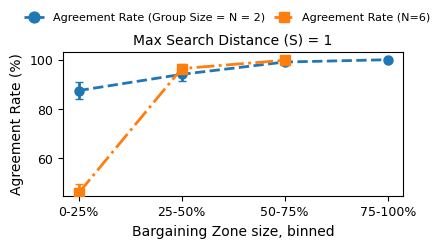

In [ ]:


def plot_generic_AR_grid(
    df: pd.DataFrame,
    *,
    # ===== Filters =====
    alpha=1.0,
    first_offer_rule="top_value",
    transition_rule=1,
    top_value=None,
    csv_source_col="csv_source",
    zopa_col="ZOPA",

    # ===== Lines and columns =====
    N_values=(2, 6),
    dmax_values=(1, 2, 3),
    scenario_type_generic_contains="Generic",
    M_filter_generic=(7,),

    # ===== Overlay control =====
    overlay_enabled=True,                     # fully toggle overlays
    overlay_metric="Mean_Offer_Count_Agree",
    overlay_label_base="Offer Count to Agreement",
    overlay_gray_colors=("#B0B0B0", "#6F6F6F", "#4A4A4A", "#2F2F2F"),

    # ===== ZOPA binning =====
    zopa_bin_pct=20,

    # ===== Figure sizing and layout =====
    figsize_per_panel=(2.6, 2.6),
    figsize=None,                             # if set, overrides per-panel sizing
    force_box_aspect=None,                    # None = free, 1.0 = square, 0.6 = short rectangles
    use_constrained=None,                     # None -> auto: False when legend_outside=True, else True
    wspace=0.02,
    hspace=0.02,

    # ===== Style =====
    marker_cycle=("o","s","D","^","v","P","X"),
    linestyle_cycle=("--","-.",":"),
    line_width=2.0,
    marker_size=6.5,
    show_se=True,
    capsize=3,
    y_top_margin_frac=0.06,
    tick_fontsize=9,
    label_fontsize=10,
    title_fontsize=10,

    # ===== Labels and titles =====
    generic_xlabel="Bargaining Zone size, binned",
    col_title_template="Max Search Distance (S) = {S}",

    # ===== Legend (outside, anchored) =====
    legend_outside=True,
    legend_loc="upper center",
    legend_anchor=(0.5, 1.02),
    legend_rows=1,
    legend_fontsize=8,
    legend_markerscale=1.2,
    legend_handlelength=1.8,
    legend_labelspacing=0.6,
    legend_columnspacing=0.8,
    legend_borderpad=0.3,

    # ===== Bottom plot control (manual scenarios) =====
    include_manual=False,
):
    if df is None or df.empty:
        raise ValueError("Input dataframe is empty.")
    if csv_source_col not in df.columns:
        raise KeyError(f"'{csv_source_col}' column is required.")

    d0 = df.copy()
    d0["csv_basename"] = d0[csv_source_col].astype(str).apply(os.path.basename)

    # numeric coercion
    for c in ["alpha","transition_rule","max_search_distance","top_value","M","N",
              "Agreement_Rate", zopa_col, "Mean_Offer_Count","Mean_Offer_Count_Agree"]:
        if c in d0.columns:
            d0[c] = pd.to_numeric(d0[c], errors="coerce")

    # generic/manual split
    if "Scenario_Type" in d0.columns:
        st = d0["Scenario_Type"].astype(str).str.lower()
        if scenario_type_generic_contains:
            needle = str(scenario_type_generic_contains).lower()
            mask_generic = st.str.contains(needle, na=False)
        else:
            # non-capturing group avoids the groups warning
            mask_generic = st.str.contains(r"\b(?:generic|rangen)\b", regex=True, na=False)
    else:
        mask_generic = d0["csv_basename"].str.contains(r"UM_N=\d+_M=\d+_", regex=True)

    # global filters
    d = d0[
        (d0["alpha"] == alpha) &
        (d0["first_offer_rule"] == first_offer_rule)
    ].copy()
    if transition_rule is not None and "transition_rule" in d.columns:
        d = d[d["transition_rule"] == transition_rule]
    if top_value is not None and "top_value" in d.columns:
        d = d[d["top_value"] == top_value]

    # generic-only filters
    Dg = d[mask_generic].copy()
    if scenario_type_generic_contains and "Scenario_Type" in Dg.columns:
        Dg = Dg[Dg["Scenario_Type"].astype(str).str.contains(
            scenario_type_generic_contains, case=False, na=False)]
    if M_filter_generic is not None and "M" in Dg.columns:
        Dg = Dg[Dg["M"].isin(list(M_filter_generic))]
    Dg = Dg[Dg["max_search_distance"].isin(dmax_values)]
    Dg = Dg[Dg["N"].isin(N_values)]

    # helpers
    def _sem(x):
        x = pd.to_numeric(x, errors="coerce"); x = x[np.isfinite(x)]
        return np.nan if x.size <= 1 else x.std(ddof=1)/np.sqrt(x.size)

    color_cycle = plt.rcParams['axes.prop_cycle'].by_key().get(
        'color', ["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b"])
    def _style_for_idx(i):
        return dict(linestyle=linestyle_cycle[i % len(linestyle_cycle)],
                    marker=marker_cycle[i % len(marker_cycle)],
                    color=color_cycle[i % len(color_cycle)])

    def _scale_to_percent_if_rate(frame, col):
        vmax = pd.to_numeric(frame[col], errors="coerce").max(skipna=True)
        return 100.0 if (np.isfinite(vmax) and vmax <= 1.0) else 1.0

    # ===== Figure size and layout =====
    n_cols = len(dmax_values)
    if figsize is not None:
        figW, figH = figsize
    else:
        figW = max(3.0, figsize_per_panel[0] * n_cols)
        figH = figsize_per_panel[1]

    if use_constrained is None:
        # If legend is outside, turn off constrained layout so figsize is strictly respected
        use_constrained = not legend_outside

    fig, axes = plt.subplots(
        1, n_cols, figsize=(figW, figH),
        constrained_layout=bool(use_constrained),
        squeeze=False
    )
    axes = axes[0, :]

    if use_constrained:
        try:
            fig.set_constrained_layout_pads(w_pad=wspace, h_pad=hspace, wspace=wspace, hspace=hspace)
        except Exception:
            pass
    else:
        # Respect user figsize; keep margins tight manually
        fig.subplots_adjust(left=0.09, right=0.94, bottom=0.14, top=0.86, wspace=wspace, hspace=hspace)

    for j, S in enumerate(dmax_values):
        axes[j].set_title(col_title_template.format(S=int(S)), fontsize=title_fontsize)

    yminG, ymaxG = np.inf, -np.inf
    legend_handles_AR = []
    overlay_data = []
    o_min, o_max = np.inf, -np.inf

    for j, S in enumerate(dmax_values):
        ax = axes[j]
        sub = Dg[Dg["max_search_distance"] == S].copy()
        if sub.empty or sub[zopa_col].dropna().empty:
            ax.text(0.5, 0.5, "No data", ha="center", va="center",
                    transform=ax.transAxes, fontsize=tick_fontsize)
            ax.set_axis_off()
            continue

        # equal-count quantile bins
        nbins = max(1, int(round(100.0 / float(zopa_bin_pct))))
        q = pd.qcut(sub[zopa_col].rank(method="average"), q=nbins, duplicates="drop")
        cats = q.cat.categories
        n_eff = len(cats)
        edges = np.linspace(0, 100, n_eff + 1, endpoint=True)
        labels = [f"{int(edges[i])}-{int(edges[i+1])}%" for i in range(n_eff)]
        lab_map = {cats[i]: labels[i] for i in range(n_eff)}  # <-- fixed bracket
        sub["bin_label"] = q.map(lab_map)

        # AR stats by bin × N
        g = (sub.groupby(["bin_label","N"], observed=False)["Agreement_Rate"]
                .agg(mean="mean", se=_sem).reset_index())

        scale = _scale_to_percent_if_rate(sub, "Agreement_Rate")
        g["mean"] *= scale; g["se"] *= scale

        order_keys = labels
        x_pos = {lab: i for i, lab in enumerate(order_keys)}

        ymin_local, ymax_local = np.inf, -np.inf
        panel_AR_handles = []

        for i, N in enumerate(N_values):
            gi = g[g["N"] == N]
            if gi.empty:
                continue
            gi = gi.set_index("bin_label").reindex(order_keys).reset_index()
            gi["x"] = gi["bin_label"].map(x_pos)
            gi = gi.sort_values("x")
            x = gi["x"].to_numpy(float)
            y = gi["mean"].to_numpy(float)
            yse = gi["se"].to_numpy(float)

            st = _style_for_idx(i)
            ln, = ax.plot(x, y, linewidth=line_width, markersize=marker_size, zorder=3, **st)

            if int(N) == 2:
                ln.set_label("Agreement Rate (Group Size = N = 2)")
            else:
                ln.set_label(f"Agreement Rate (N={int(N)})")

            panel_AR_handles.append(ln)

            if show_se and np.isfinite(yse).any():
                ax.errorbar(x, y, yerr=yse, fmt="none",
                            ecolor=ln.get_color(), elinewidth=line_width,
                            capsize=capsize, zorder=3)

            if y.size:
                ymin_local = min(ymin_local, np.nanmin(y))
                ymax_local = max(ymax_local, np.nanmax(y))

        # overlay (only if enabled)
        Nmap = {}
        if overlay_enabled and (overlay_metric in sub.columns):
            ov = (sub.groupby(["bin_label","N"], observed=False)[overlay_metric]
                    .mean().reset_index())
            for i, N in enumerate(N_values):
                ovi = ov[ov["N"] == N]
                if ovi.empty:
                    continue
                ovi = ovi.set_index("bin_label").reindex(order_keys)
                x_overlay = np.array([x_pos[k] for k in order_keys], float)
                y_overlay = ovi[overlay_metric].to_numpy(float)
                Nmap[int(N)] = (x_overlay, y_overlay)
                if y_overlay.size:
                    o_min = min(o_min, np.nanmin(y_overlay))
                    o_max = max(o_max, np.nanmax(y_overlay))

        overlay_data.append((ax, Nmap if overlay_enabled else {}))

        # cosmetics
        ax.set_xticks(range(len(order_keys)))
        ax.set_xticklabels(order_keys, rotation=0, fontsize=tick_fontsize)
        ax.set_xlabel(generic_xlabel, fontsize=label_fontsize)
        ax.tick_params(axis="y", labelsize=tick_fontsize)
        if j == 0:
            ax.set_ylabel("Agreement Rate (%)", fontsize=label_fontsize)
        else:
            ax.set_ylabel("")

        # aspect control
        if force_box_aspect is not None:
            try:
                ax.set_box_aspect(float(force_box_aspect))
            except Exception:
                pass

        if np.isfinite(ymin_local) and np.isfinite(ymax_local):
            yminG = min(yminG, ymin_local)
            ymaxG = max(ymaxG, ymax_local)

        if len(panel_AR_handles) > len(legend_handles_AR):
            legend_handles_AR = panel_AR_handles

    overlay_handles_for_legend = []
    if np.isfinite(yminG) and np.isfinite(ymaxG):
        span = max(1e-6, ymaxG - yminG)
        y0 = yminG - 0.02 * span
        y1 = ymaxG + y_top_margin_frac * span
        for ax in axes:
            if ax.has_data():
                ax.set_ylim(y0, y1)

        if overlay_enabled:
            if not (np.isfinite(o_min) and np.isfinite(o_max)):
                o_min, o_max = 0.0, 1.0
            if o_max == o_min:
                o_min, o_max = o_min - 0.5, o_max + 0.5

            def o_to_y_factory(Y0, Y1):
                def o_to_y(v):
                    return Y0 + (v - o_min) * (Y1 - Y0) / (o_max - o_min)
                return o_to_y
            def y_to_o_factory(Y0, Y1):
                def y_to_o(y):
                    return o_min + (y - Y0) * (o_max - o_min) / (Y1 - Y0)
                return y_to_o

            for j, (ax, Nmap) in enumerate(overlay_data):
                if not ax.has_data():
                    continue
                Y0, Y1 = ax.get_ylim()
                o_to_y = o_to_y_factory(Y0, Y1)
                y_to_o = y_to_o_factory(Y0, Y1)

                for i, N in enumerate(N_values):
                    if int(N) not in Nmap:
                        continue
                    x_overlay, y_overlay = Nmap[int(N)]
                    y_on_left = o_to_y(y_overlay)
                    gray = overlay_gray_colors[i % len(overlay_gray_colors)]
                    marker = marker_cycle[i % len(marker_cycle)]
                    h = ax.plot(
                        x_overlay, y_on_left,
                        color=gray, linestyle="-", marker=marker,
                        linewidth=line_width, markersize=marker_size,
                        zorder=1,
                        label=f"{overlay_label_base} (N={int(N)})"
                    )[0]
                    if j == 0:
                        overlay_handles_for_legend.append(h)

                ax2 = ax.secondary_yaxis('right', functions=(y_to_o, o_to_y))
                if j == len(axes) - 1:
                    ax2.set_ylabel(overlay_label_base, fontsize=label_fontsize)
                    ax2.tick_params(axis="y", labelsize=tick_fontsize)
                else:
                    ax2.set_yticklabels([])
                    ax2.set_ylabel("")

        # legend
        leg_handles = []
        if legend_handles_AR: leg_handles.extend(legend_handles_AR)
        if overlay_enabled and overlay_handles_for_legend:
            leg_handles.extend(overlay_handles_for_legend)

        if leg_handles:
            if legend_outside:
                ncol = max(1, ceil(len(leg_handles) / max(1, legend_rows)))
                fig.legend(
                    leg_handles, [h.get_label() for h in leg_handles],
                    loc=legend_loc, bbox_to_anchor=legend_anchor,
                    frameon=False, fontsize=legend_fontsize, ncol=ncol,
                    markerscale=legend_markerscale, handlelength=legend_handlelength,
                    labelspacing=legend_labelspacing, columnspacing=legend_columnspacing,
                    borderpad=legend_borderpad
                )
            else:
                ncol = max(1, ceil(len(leg_handles) / max(1, legend_rows)))
                axes[-1].legend(
                    leg_handles, [h.get_label() for h in leg_handles],
                    loc="upper left", bbox_to_anchor=(0.02, 0.98),
                    frameon=False, fontsize=legend_fontsize, ncol=ncol,
                    markerscale=legend_markerscale, handlelength=legend_handlelength,
                    labelspacing=legend_labelspacing, columnspacing=legend_columnspacing,
                    borderpad=legend_borderpad
                )

    return (fig, axes), (None, None)

# -------------------------- Run code --------------------------
# Example: rectangular, overlays off, legend outside, width responds
(fig, axes), _ = plot_generic_AR_grid(
    df,
    alpha=1.0,
    first_offer_rule="top_value",
    transition_rule=2,
    top_value=3,
    csv_source_col="csv_source",
    zopa_col="ZOPA",
    N_values=(2, 6),
    dmax_values=(1,),
    scenario_type_generic_contains=None,
    M_filter_generic=(8,),

    overlay_enabled=False,     # hides overlay lines, right axis, legend entries
    legend_outside=True,
    legend_loc="upper center",
    legend_anchor=(0.5, 1.1),

    figsize=(4, 2),         # wide and short
    force_box_aspect=None,     # allow rectangles
    use_constrained=None,      # auto False because legend_outside=True

    zopa_bin_pct=20,
    tick_fontsize=9,
    label_fontsize=10,
    title_fontsize=10,
)
plt.show(fig)


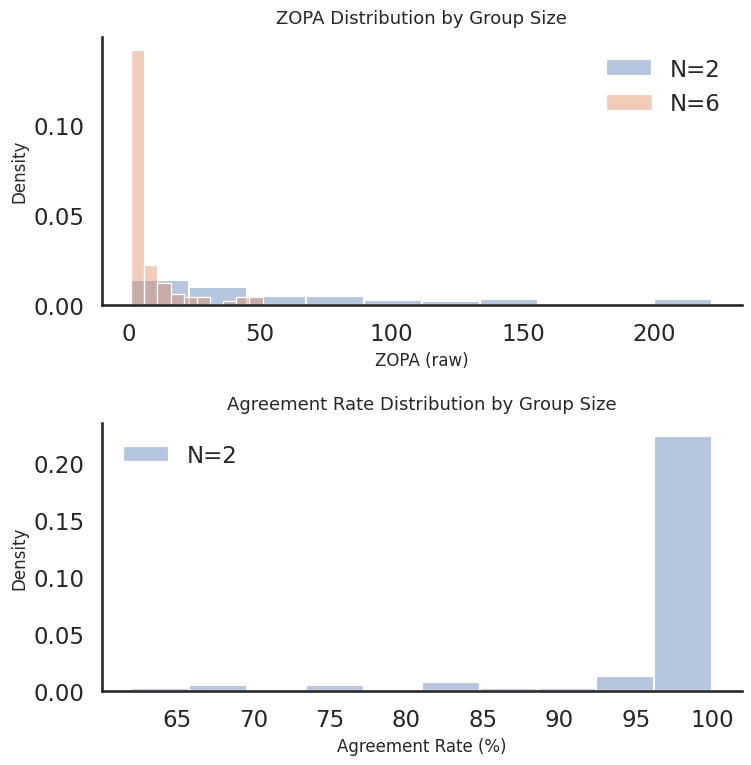

In [ ]:


def plot_zopa_ar_distribution(df, *, use_kde=True, figsize=(8, 5), bins=20):
    """
    Plots either KDE (density) or histogram for ZOPA and Agreement Rate
    by group size (N=2 vs N=6).
    Toggle between them using `use_kde=True` or False.
    """

    d = df.copy()
    for c in ["ZOPA", "Agreement_Rate", "N"]:
        if c in d.columns:
            d[c] = pd.to_numeric(d[c], errors="coerce")
    d = d[d["N"].isin([2, 6])].dropna(subset=["ZOPA", "Agreement_Rate"], how="all")

    def to_pct_if_needed(series):
        series = pd.to_numeric(series, errors="coerce").dropna()
        if series.empty:
            return series, False
        if series.max() <= 1.01:
            return series * 100.0, True
        return series, False

    sns.set_theme(style="white", context="talk")
    palette = {"N=2": "#4C72B0", "N=6": "#DD8452"}
    n_labels = {2: "N=2", 6: "N=6"}

    fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=False)
    ax_zopa, ax_ar = axes

    # ---------- ZOPA ----------
    for N in [2, 6]:
        subset = d.loc[d["N"] == N, "ZOPA"].dropna()
        if len(subset) > 1:
            xmin = max(0, subset.min())
            xmax = subset.max()
            if use_kde:
                sns.kdeplot(
                    subset,
                    ax=ax_zopa,
                    fill=True,
                    alpha=0.35,
                    linewidth=2.0,
                    label=n_labels[N],
                    color=palette[n_labels[N]],
                    clip=(xmin, xmax),
                    bw_adjust=1.0,
                    common_norm=False,
                )
            else:
                sns.histplot(
                    subset,
                    ax=ax_zopa,
                    bins=bins,
                    kde=False,
                    stat="density",
                    color=palette[n_labels[N]],
                    label=n_labels[N],
                    alpha=0.4,
                )

    ax_zopa.set_xlabel("ZOPA (raw)", fontsize=12)
    ax_zopa.set_ylabel("Density", fontsize=12)
    ax_zopa.set_title("ZOPA Distribution by Group Size", fontsize=13, pad=10)
    ax_zopa.legend(frameon=False)
    ax_zopa.spines[['top','right']].set_visible(False)

    # ---------- Agreement Rate ----------
    for N in [2, 6]:
        subset = d.loc[d["N"] == N, "Agreement_Rate"].dropna()
        subset, is_pct = to_pct_if_needed(subset)
        if len(subset) > 1:
            xmin = max(0, subset.min())
            xmax = subset.max()
            if use_kde:
                sns.kdeplot(
                    subset,
                    ax=ax_ar,
                    fill=True,
                    alpha=0.35,
                    linewidth=2.0,
                    label=n_labels[N],
                    color=palette[n_labels[N]],
                    clip=(xmin, xmax),
                    bw_adjust=1.0,
                    common_norm=False,
                )
            else:
                sns.histplot(
                    subset,
                    ax=ax_ar,
                    bins=bins,
                    kde=False,
                    stat="density",
                    color=palette[n_labels[N]],
                    label=n_labels[N],
                    alpha=0.4,
                )

    ax_ar.set_xlabel(f"Agreement Rate{' (%)' if is_pct else ''}", fontsize=12)
    ax_ar.set_ylabel("Density", fontsize=12)
    ax_ar.set_title("Agreement Rate Distribution by Group Size", fontsize=13, pad=10)
    ax_ar.legend(frameon=False)
    ax_ar.spines[['top','right']].set_visible(False)

    plt.subplots_adjust(hspace=0)
    plt.tight_layout()
    plt.show()

# ---------------- Run example ----------------
# Change `use_kde` to False for histograms
plot_zopa_ar_distribution(df, use_kde=False, figsize=(8, 8), bins=10)


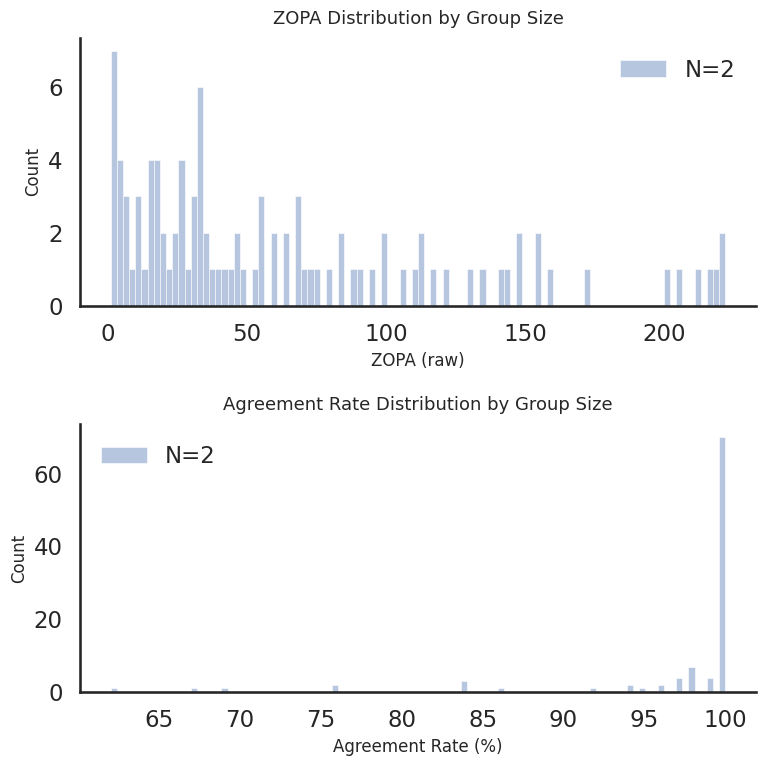

In [ ]:


def plot_zopa_ar_distribution(df, *, use_kde=True, figsize=(8, 5), bins=20, N_filter=None):
    """
    Plots either KDE (density) or histogram for ZOPA and Agreement Rate
    by group size (N=2 vs N=6).
    Toggle with `use_kde=True` or False.
    You can filter specific group sizes with `N_filter=[2]` or [6].
    """

    d = df.copy()
    for c in ["ZOPA", "Agreement_Rate", "N"]:
        if c in d.columns:
            d[c] = pd.to_numeric(d[c], errors="coerce")

    # filter which N values to include
    if N_filter is None:
        N_filter = [2, 6]
    d = d[d["N"].isin(N_filter)].dropna(subset=["ZOPA", "Agreement_Rate"], how="all")

    def to_pct_if_needed(series):
        series = pd.to_numeric(series, errors="coerce").dropna()
        if series.empty:
            return series, False
        if series.max() <= 1.01:
            return series * 100.0, True
        return series, False

    sns.set_theme(style="white", context="talk")
    palette = {"N=2": "#4C72B0", "N=6": "#DD8452"}
    n_labels = {2: "N=2", 6: "N=6"}

    fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=False)
    ax_zopa, ax_ar = axes

    # ---------- ZOPA ----------
    for N in N_filter:
        subset = d.loc[d["N"] == N, "ZOPA"].dropna()
        if len(subset) > 1:
            xmin = max(0, subset.min())
            xmax = subset.max()
            if use_kde:
                sns.kdeplot(
                    subset,
                    ax=ax_zopa,
                    fill=True,
                    alpha=0.35,
                    linewidth=2.0,
                    label=n_labels.get(N, f"N={N}"),
                    color=palette.get(n_labels.get(N, f"N={N}"), "#888888"),
                    clip=(xmin, xmax),
                    bw_adjust=1.0,
                    common_norm=False,
                )
            else:
                sns.histplot(
                    subset,
                    ax=ax_zopa,
                    bins=bins,
                    kde=False,
                    stat="count",   # histogram shows counts
                    color=palette.get(n_labels.get(N, f"N={N}"), "#888888"),
                    label=n_labels.get(N, f"N={N}"),
                    alpha=0.4,
                )

    ax_zopa.set_xlabel("ZOPA (raw)", fontsize=12)
    ax_zopa.set_ylabel("Count" if not use_kde else "Density", fontsize=12)
    ax_zopa.set_title("ZOPA Distribution by Group Size", fontsize=13, pad=10)
    ax_zopa.legend(frameon=False)
    ax_zopa.spines[['top','right']].set_visible(False)

    # ---------- Agreement Rate ----------
    for N in N_filter:
        subset = d.loc[d["N"] == N, "Agreement_Rate"].dropna()
        subset, is_pct = to_pct_if_needed(subset)
        if len(subset) > 1:
            xmin = max(0, subset.min())
            xmax = subset.max()
            if use_kde:
                sns.kdeplot(
                    subset,
                    ax=ax_ar,
                    fill=True,
                    alpha=0.35,
                    linewidth=2.0,
                    label=n_labels.get(N, f"N={N}"),
                    color=palette.get(n_labels.get(N, f"N={N}"), "#888888"),
                    clip=(xmin, xmax),
                    bw_adjust=1.0,
                    common_norm=False,
                )
            else:
                sns.histplot(
                    subset,
                    ax=ax_ar,
                    bins=bins,
                    kde=False,
                    stat="count",   # histogram shows counts
                    color=palette.get(n_labels.get(N, f"N={N}"), "#888888"),
                    label=n_labels.get(N, f"N={N}"),
                    alpha=0.4,
                )

    ax_ar.set_xlabel(f"Agreement Rate{' (%)' if is_pct else ''}", fontsize=12)
    ax_ar.set_ylabel("Count" if not use_kde else "Density", fontsize=12)
    ax_ar.set_title("Agreement Rate Distribution by Group Size", fontsize=13, pad=10)
    ax_ar.legend(frameon=False)
    ax_ar.spines[['top','right']].set_visible(False)

    plt.subplots_adjust(hspace=0.25)
    plt.tight_layout()
    plt.show()

# ---------------- Run example ----------------
# Example: only N=2, with histogram counts
plot_zopa_ar_distribution(df, use_kde=False, N_filter=[2], figsize=(8, 8), bins=100)


## OPTIONAL 2 - Simulation application to compare agreement rate of two scenarios
Used for the empirical project

In [ ]:
# ── PARAMETERS ──────────────────────────────────────────────────────────────
num_simulations = 100
random_seed     = 1

# alpha grid (example)
learning_rate        = [0, 1]
learning_rate_delta  = [0]

# First offer rules
first_offer_rule     = ['top_value', 'random']   # could also include ['meso','random']
top_value            = [3]

# Search rules
agreement_rule       = [3]
transition_rule      = [1, 2]
max_search_distance  = [1, 2, 3]

# Toggles
include_filler_offers = True
apply_post_processing = False
record_full_histories = True
summarize_payoffs     = True
add_deadline          = True

# Noise parameters
beta                 = [0]
beta_delta           = [0]
beta_memory          = 1
gamma                = [0]
gamma_delta          = [0]
gamma_dist           = 1
theta                = [0]
theta_delta          = [0]
theta_override_alpha = True

# ── MANUAL / GENERIC MODE ───────────────────────────────────────────────────
run_mode = "manual"

# Generic mode choices
N_filters            = [2, 6]     # ← filter by group size N (set to None to ignore)
M_filters            = [8]     # ← NEW: filter by issue count M (set to None to ignore)
Manual_limit_per_N   = 100   # optional cap per N (still applies after N/M filtering)

exclude_all_zero_consensus=True, #normally keep as false

##############################################################################
csv_list = []
extra_csv_folder = None

if run_mode in ("manual", "both"):
    csv_file_names = [
        "party3_easy_transition_analysis.csv",
        "party3_hard_transition_analysis.csv",
    ]
    csv_list_manual = [str(S1_OUTPUT / name) for name in csv_file_names]
else:
    csv_list_manual = []

if run_mode in ("generic", "both"):
    # Grab all candidate CSVs from S1 output
    all_csvs = sorted(S1_OUTPUT.glob("*.csv"))
    csv_list_generic = []

    # Helper: decide if a filename matches the N/M filters
    # Files look like "UM_N=6_M=7_999.csv" (your convention)
    import re
    pat = re.compile(r"UM_N=(\d+)_M=(\d+)_")

    def match_nm(pathname, Ns, Ms):
        m = pat.search(pathname)
        if not m:
            return False
        n_val = int(m.group(1))
        m_val = int(m.group(2))
        n_ok = (Ns is None) or (len(Ns) == 0) or (n_val in Ns)
        m_ok = (Ms is None) or (len(Ms) == 0) or (m_val in Ms)
        return n_ok and m_ok

    # Build list based on provided filters
    selected = [f for f in all_csvs if match_nm(f.name, N_filters, M_filters)]

    # Optionally cap per-N after filtering by M as well
    if Manual_limit_per_N:
        # bucket by N, then take first k for each N
        from collections import defaultdict
        buckets = defaultdict(list)
        for f in selected:
            m = pat.search(f.name)
            if not m:
                continue
            n_val = int(m.group(1))
            buckets[n_val].append(f)
        capped = []
        for n_val, files in buckets.items():
            files = sorted(files)
            capped.extend(files[:Manual_limit_per_N])
        selected = capped

    csv_list_generic = [str(f) for f in selected]
else:
    csv_list_generic = []

if run_mode == "manual":
    csv_list = csv_list_manual
elif run_mode == "generic":
    csv_list = csv_list_generic
elif run_mode == "both":
    seen = set()
    csv_list = []
    for p in csv_list_manual + csv_list_generic:
        if p not in seen:
            seen.add(p)
            csv_list.append(p)
else:
    raise ValueError("run_mode must be 'manual', 'generic', or 'both'.")

# Deadlines we want baked into the summary (same as your analysis defaults)
DEADLINE_TIME_LIMITS = list(range(0, 101, 2))  # 0,2,4,...,100

# ── RUN ─────────────────────────────────────────────────────────────────────
summary_df_adv = main_search_model(
    csv_list=csv_list,
    extra_csv_folder=extra_csv_folder,
    output_path=S2_OUTPUT,
    num_simulations=num_simulations,
    learning_rate=learning_rate,
    learning_rate_delta=learning_rate_delta,
    max_search_distance=max_search_distance,
    first_offer_rule=first_offer_rule,
    top_value=top_value,
    agreement_rule=agreement_rule,
    transition_rule=transition_rule,
    random_seed=random_seed,
    include_filler_offers=include_filler_offers,
    apply_post_processing=apply_post_processing,
    record_full_histories=record_full_histories,
    summarize_payoffs=summarize_payoffs,
    add_deadline_columns=add_deadline,
    deadline_time_limits=DEADLINE_TIME_LIMITS,
)

# ── SAVE ────────────────────────────────────────────────────────────────────
save_results(summary_df_adv, dest_folder=S2_OUTPUT)

# PRINT
summary_df_adv


Plan: 2 source CSVs | fo×tv×agr×trn×dmax = 2×1×1×2×3 | a0/da=2/1  b0/db=1/1  g0/dg=1/1  t0/dt=1/1 | scenario-combos=48


Simulations: 100%|██████████| 4800/4800 [04:04<00:00, 19.67run/s, party3_hard_transition_analysis.csv | fo=random tv=3 agr=3 trn=2 dmax=3]


Saved results to /content/drive/MyDrive/Negotiations-as-Search/S2_OUTPUT/simulation_20251109_010928


,simulation_code,csv_source,S2_OUTPUT_folder,Scenario_Type,possible_solutions,ZOPA,ZOPA_Pct,N,M,Agreement_Rate,...,P3_PayFirstOfferNoAgree,P3_PayNotFirstOfferAgree,P3_PayNotFirstOfferNoAgree,P3_AgreeWhenFirst,P3_AgreeWhenNotFirst,P3_FLDistFirst,P3_FLDistNotFirst,P3_FLDistFirstAgree,P3_FLDistFirstNoAgree,P3_FirstOfferAdv_Prob
0,party3_easy_transition_analysis__tr1_S1_fo_top...,party3_easy_transition_analysis.csv,/content/drive/MyDrive/Negotiations-as-Search/...,Manual,256,21,0.082,3,8,0.91,...,0.0,1.62,0.0,0.90,0.92,1.90,3.72,1.58,4.67,0.480
1,party3_easy_transition_analysis__tr1_S1_fo_top...,party3_easy_transition_analysis.csv,/content/drive/MyDrive/Negotiations-as-Search/...,Manual,256,21,0.082,3,8,0.41,...,0.0,0.66,0.0,0.86,0.23,1.34,1.48,1.24,2.00,0.960
2,party3_easy_transition_analysis__tr1_S2_fo_top...,party3_easy_transition_analysis.csv,/content/drive/MyDrive/Negotiations-as-Search/...,Manual,256,21,0.082,3,8,1.00,...,NaN,1.34,NaN,1.00,1.00,2.31,3.62,2.31,NaN,0.520
3,party3_easy_transition_analysis__tr1_S2_fo_top...,party3_easy_transition_analysis.csv,/content/drive/MyDrive/Negotiations-as-Search/...,Manual,256,21,0.082,3,8,0.96,...,0.0,0.99,0.0,0.97,0.96,2.10,2.66,2.04,4.00,0.720
4,party3_easy_transition_analysis__tr1_S3_fo_top...,party3_easy_transition_analysis.csv,/content/drive/MyDrive/Negotiations-as-Search/...,Manual,256,21,0.082,3,8,1.00,...,NaN,0.97,NaN,1.00,1.00,2.66,3.49,2.66,NaN,0.620
5,party3_easy_transition_analysis__tr1_S3_fo_top...,party3_easy_transition_analysis.csv,/content/drive/MyDrive/Negotiations-as-Search/...,Manual,256,21,0.082,3,8,1.00,...,NaN,1.01,NaN,1.00,1.00,2.38,3.25,2.38,NaN,0.570
6,party3_easy_transition_analysis__tr2_S1_fo_top...,party3_easy_transition_analysis.csv,/content/drive/MyDrive/Negotiations-as-Search/...,Manual,256,21,0.082,3,8,1.00,...,NaN,1.68,NaN,1.00,1.00,1.66,3.77,1.66,NaN,0.760
7,party3_easy_transition_analysis__tr2_S1_fo_top...,party3_easy_transition_analysis.csv,/content/drive/MyDrive/Negotiations-as-Search/...,Manual,256,21,0.082,3,8,0.96,...,0.0,0.98,0.0,0.97,0.96,1.79,3.31,1.68,5.00,0.850
8,party3_easy_transition_analysis__tr2_S2_fo_top...,party3_easy_transition_analysis.csv,/content/drive/MyDrive/Negotiations-as-Search/...,Manual,256,21,0.082,3,8,1.00,...,NaN,1.37,NaN,1.00,1.00,2.24,3.68,2.24,NaN,0.510
9,party3_easy_transition_analysis__tr2_S2_fo_top...,party3_easy_transition_analysis.csv,/content/drive/MyDrive/Negotiations-as-Search/...,Manual,256,21,0.082,3,8,1.00,...,NaN,0.94,NaN,1.00,1.00,2.62,3.24,2.62,NaN,0.520


Saved CSV → /content/drive/MyDrive/Negotiations-as-Search/S2_OUTPUT/agreement_rate_matrix_all.csv


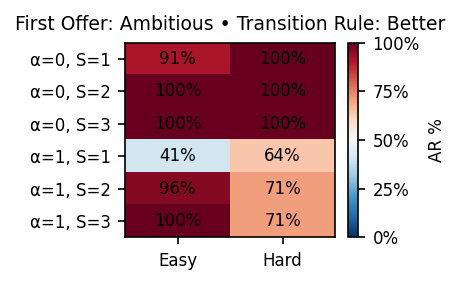

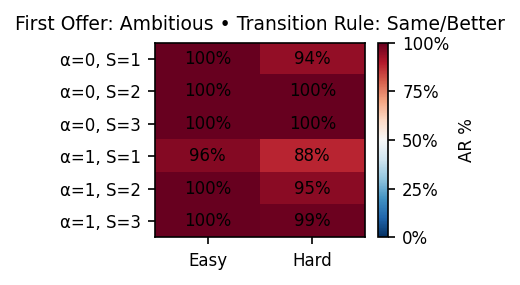

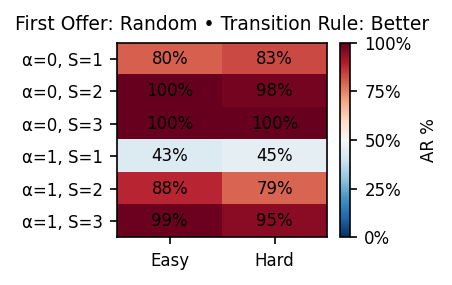

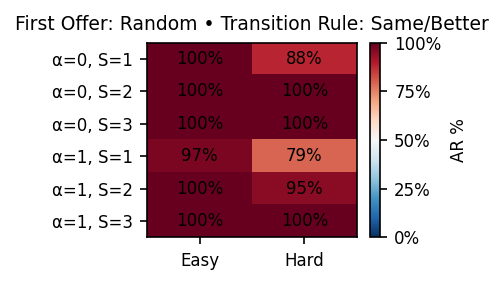

In [ ]:
# === Agreement-rate CSV + on-screen heatmaps (no image files saved) ===
# Assumes: summary_df_adv and S2_OUTPUT exist.

HEATMAP_FIG_W, HEATMAP_FIG_H = 3.0, 2.0  # your preferred size

# -----------------------------
# 0) Setup + safe cleanup
# -----------------------------
out_dir = Path(S2_OUTPUT) if not isinstance(S2_OUTPUT, Path) else S2_OUTPUT
out_dir.mkdir(parents=True, exist_ok=True)

for pattern in [
    "agreement_rate_heatmap_*.png",
    "agreement_rate_matrix.csv",
    "agreement_rate_matrix_all.csv",
    "agreement_rate_matrix_*.csv",
]:
    for p in out_dir.glob(pattern):
        try:
            p.unlink()
        except Exception:
            pass

# -----------------------------
# 1) Filter to your spec
# -----------------------------
df = summary_df_adv.copy()

def _difficulty_from_csv(s: str) -> str:
    s = str(s).lower().strip()
    if re.search(r'(?<![a-z0-9])easy(?![a-z0-9])', s):
        return "Easy"
    if re.search(r'(?<![a-z0-9])hard(?![a-z0-9])', s):
        return "Hard"
    return "Unknown"

df["Difficulty"] = df["csv_source"].apply(_difficulty_from_csv)
df = df[df["Difficulty"].isin(["Easy", "Hard"])]

mask = (
    df["first_offer_rule"].isin(["top_value", "random"]) &
    df["transition_rule"].isin([1, 2]) &
    (df["top_value"] == 3) &
    (df["gamma"] == 0) &
    (df["beta"] == 0) &
    (df["theta"] == 0) &
    df["alpha"].isin([0, 1]) &
    df["max_search_distance"].isin([1, 2, 3])
)
f = df.loc[mask].copy()

rows_in_order = [(0,1),(0,2),(0,3),(1,1),(1,2),(1,3)]
f["row_key"] = list(zip(f["alpha"], f["max_search_distance"]))
f = f[f["row_key"].isin(rows_in_order)]

# Friendly labels
FO_LABEL = {"top_value": "Ambitious", "random": "Random"}
TR_LABEL = {1: "Better", 2: "Same/Better"}

# -----------------------------
# 2) One tidy CSV across all combos with friendly columns
#    Columns: First Offer, Transition Rule, alpha, S, Easy, Hard
# -----------------------------
tidy = (
    f.groupby(["first_offer_rule","transition_rule","Difficulty","alpha","max_search_distance"], as_index=False)
     .agg(Agreement_Rate_mean=("Agreement_Rate","mean"))
)

wide = (
    tidy.pivot_table(index=["first_offer_rule","transition_rule","alpha","max_search_distance"],
                     columns="Difficulty",
                     values="Agreement_Rate_mean",
                     aggfunc="mean")
         .reset_index()
)

# Map friendly labels
wide["First Offer"] = wide["first_offer_rule"].map(FO_LABEL).fillna(wide["first_offer_rule"])
wide["Transition Rule"] = wide["transition_rule"].map(TR_LABEL).fillna(wide["transition_rule"])
wide.rename(columns={"alpha": "alpha", "max_search_distance": "S"}, inplace=True)

# Reorder rows by α×S within each FO×TR block
order_df = pd.DataFrame(rows_in_order, columns=["alpha","S"])
wide = (
    order_df.merge(wide, on=["alpha","S"], how="left")
            .sort_values(by=["First Offer","Transition Rule","alpha","S"], kind="mergesort")
)

# Final column order
cols = ["First Offer","Transition Rule","alpha","S","Easy","Hard"]
wide = wide[cols]

csv_path = out_dir / "agreement_rate_matrix_all.csv"
wide.to_csv(csv_path, index=False, float_format="%.3f")
print(f"Saved CSV → {csv_path}")

# -----------------------------
# 3) Heatmaps per (First Offer, Transition Rule) — display only
# -----------------------------
def _plot_heatmap_for_pair(sub_df: pd.DataFrame, fo_raw, tr_raw):
    # Labels for title
    fo_label = FO_LABEL.get(fo_raw, str(fo_raw))
    tr_label = TR_LABEL.get(int(tr_raw), str(tr_raw))

    # 6×2 matrix: rows=(alpha,S), cols=Easy/Hard
    mat = (
        sub_df.groupby(["Difficulty","alpha","max_search_distance"], as_index=False)["Agreement_Rate"]
              .mean()
              .pivot_table(index=["alpha","max_search_distance"],
                           columns="Difficulty",
                           values="Agreement_Rate",
                           aggfunc="mean")
              .reindex(rows_in_order)
    )
    if mat.empty:
        print(f"[skip] No data for First Offer={fo_label}, Transition Rule={tr_label}")
        return

    for col in ["Easy","Hard"]:
        if col not in mat.columns:
            mat[col] = np.nan
    mat = mat[["Easy","Hard"]]

    vals = np.ma.masked_invalid(mat.values.astype(float))  # for clean display

    # Pretty row labels
    mat.index = pd.Index([f"α={a}, S={s}" for a, s in mat.index], name="Condition")

    fig, ax = plt.subplots(figsize=(HEATMAP_FIG_W, HEATMAP_FIG_H), dpi=150)

    # Red–blue, clamp [0,1]
    im = ax.imshow(vals, aspect="auto", cmap="RdBu_r", vmin=0.0, vmax=1.0)

    # Ticks/labels
    ax.set_xticks(range(len(mat.columns)))
    ax.set_xticklabels(mat.columns, fontsize=8)
    ax.set_yticks(range(len(mat.index)))
    ax.set_yticklabels(mat.index, fontsize=8)

    # Smaller title and friendlier wording
    ax.set_title(f"First Offer: {fo_label} • Transition Rule: {tr_label}", fontsize=9)

    # Annotate cells with percent
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            if not vals.mask[i, j]:
                ax.text(j, i, f"{float(vals[i, j])*100:.0f}%", ha="center", va="center", fontsize=8)

    # Percent colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x*100:.0f}%"))
    cbar.set_label("AR %", fontsize=8)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontsize(8)

    plt.tight_layout()
    plt.show()

# Loop over all pairs and plot
pairs = f[["first_offer_rule","transition_rule"]].drop_duplicates()
for _, row in pairs.iterrows():
    fo_raw, tr_raw = row["first_offer_rule"], int(row["transition_rule"])
    sub = f[(f["first_offer_rule"] == fo_raw) & (f["transition_rule"] == tr_raw)]
    _plot_heatmap_for_pair(sub, fo_raw, tr_raw)


In [ ]:
# === ZOPA (consensus nodes) per file, labeled Easy/Hard ===
# Assumes: summary_df_adv and S2_OUTPUT are already defined.



# -----------------------------
# Settings
# -----------------------------
EXCLUDE_ZERO_CONSENSUS = True  # toggle to ignore "000...0" as consensus
ZOPA_CSV_NAME = "zopa_consensus_nodes_by_file.csv"

# -----------------------------
# 0) Setup + safe cleanup
# -----------------------------
out_dir = Path(S2_OUTPUT) if not isinstance(S2_OUTPUT, Path) else S2_OUTPUT
out_dir.mkdir(parents=True, exist_ok=True)

for pattern in ["zopa_*.csv"]:
    for p in out_dir.glob(pattern):
        try:
            p.unlink()
        except Exception:
            pass  # ignore if already gone

# If you also want to remove a previously saved specific file name:
for p in [out_dir / ZOPA_CSV_NAME]:
    try:
        p.unlink()
    except Exception:
        pass

# -----------------------------
# 1) Helpers
# -----------------------------
def _difficulty_from_csv(s: str) -> str:
    s = str(s).lower().strip()
    if re.search(r'(?<![a-z0-9])easy(?![a-z0-9])', s):
        return "Easy"
    if re.search(r'(?<![a-z0-9])hard(?![a-z0-9])', s):
        return "Hard"
    return "Unknown"

def _resolve_csv_path(name_or_path: str):
    """
    Try to find the raw transition CSV referenced by summary_df_adv['csv_source'].
    Attempts:
      1) as given (absolute or relative)
      2) under S1_OUTPUT (if defined in your session)
      3) under S2_OUTPUT (same folder you use for step-2 outputs)
    """
    p = Path(name_or_path)
    if p.exists():
        return p
    # S1_OUTPUT may exist in your environment; try it if present
    try:
        base1 = Path(S1_OUTPUT)  # noqa: F821 if not defined in your session
        p1 = base1 / Path(name_or_path).name
        if p1.exists():
            return p1
    except NameError:
        pass
    # fallback: look in S2_OUTPUT by basename
    p2 = out_dir / Path(name_or_path).name
    if p2.exists():
        return p2
    raise FileNotFoundError(f"Could not locate CSV: {name_or_path}")

def _set_agreement_threshold(df: pd.DataFrame, N: int, rule_choice: int) -> pd.DataFrame:
    """Minimal replica of your agreement threshold logic for rules 1–3."""
    df = df.copy()
    if rule_choice == 1:
        # simple majority: strictly greater than floor(N/2)
        df['Origin_Agreement'] = (df['Origin_votes'] > (N // 2)).astype(int)
        df['Destination_Agreement'] = (df['Destination_votes'] > (N // 2)).astype(int)
    elif rule_choice == 2:
        # max votes minus one (needs the max in this file)
        agreement_threshold = int(df['Origin_votes'].max()) - 1
        # veto omitted here since many of your CSVs don’t include it consistently
        df['Origin_Agreement'] = (df['Origin_votes'] >= agreement_threshold).astype(int)
        df['Destination_Agreement'] = (df['Destination_votes'] >= agreement_threshold).astype(int)
    elif rule_choice == 3:
        # unanimity
        df['Origin_Agreement'] = (df['Origin_votes'] == N).astype(int)
        df['Destination_Agreement'] = (df['Destination_votes'] == N).astype(int)
    else:
        raise ValueError("rule_choice must be 1, 2, or 3")
    return df

# -----------------------------
# 2) Collect unique sources + the agreement rules you actually used
# -----------------------------
src_rules = (
    summary_df_adv[["csv_source", "agreement_rule"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

# -----------------------------
# 3) Compute ZOPA and consensus lists per file (by the rule used)
# -----------------------------
records = []
for _, row in src_rules.iterrows():
    src = str(row["csv_source"])
    agr = int(row["agreement_rule"])
    path = _resolve_csv_path(src)

    df_raw = pd.read_csv(path)
    # Derive N as the max observed vote count in the file (matches what your run code did)
    N = int(df_raw["Origin_votes"].max())

    df_ag = _set_agreement_threshold(df_raw, N, rule_choice=agr)

    # base consensus detection at Destination nodes
    cons_mask = df_ag["Destination_Agreement"].eq(1)
    if EXCLUDE_ZERO_CONSENSUS:
        zero_mask = df_ag["Destination"].astype(str).str.fullmatch(r"2+")
        cons_mask = cons_mask & (~zero_mask)

    con_nodes = sorted(df_ag.loc[cons_mask, "Destination"].astype(str).unique().tolist())
    zopa = len(con_nodes)

    rec = {
        "csv_source": Path(src).name,
        "Difficulty": _difficulty_from_csv(src),
        "Agreement_Rule": agr,
        "N": N,
        "ZOPA": zopa,
        "Consensus_Nodes": ";".join(con_nodes)  # semicolon-separated list
    }
    records.append(rec)

zopa_df = pd.DataFrame(records).sort_values(by=["Difficulty","csv_source","Agreement_Rule"]).reset_index(drop=True)

# -----------------------------
# 4) Save ONE tidy CSV
# -----------------------------
out_csv = out_dir / ZOPA_CSV_NAME
zopa_df.to_csv(out_csv, index=False)
print(f"Saved ZOPA summary → {out_csv}")

# Optional: quick display in notebook
zopa_df


Saved ZOPA summary → /content/drive/MyDrive/Negotiations-as-Search/S2_OUTPUT/zopa_consensus_nodes_by_file.csv


,csv_source,Difficulty,Agreement_Rule,N,ZOPA,Consensus_Nodes
0,party3_easy_transition_analysis.csv,Easy,3,3,20,11111121;11111221;11111222;11112121;11112221;1...
1,party3_hard_transition_analysis.csv,Hard,3,3,20,11122112;11122212;11212112;11212212;11221112;1...
